# Data Analyst Professional Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.


## 📝 Task List

Your written report should include written text summaries and graphics of the following:
- Data validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Definition of a metric for the business to monitor  
  - How should the business use the metric to monitor the business problem
  - Can you estimate initial value(s) for the metric based on the current data
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# **Understanding data**

First, we will import all the necessary packages that we will be working with.

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm
from scipy.stats import shapiro
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Next, we will import data from a CSV file using pandas and examine the first 5 rows to understand the data's structure.

In [2]:
df = pd.read_csv('product_sales.csv')
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


Using the .info() method will help us to check for any columns that have missing values. Additionally, it will display the data type of each column. Following this, the .isna().sum() method will provide a clearer view of the number of missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [4]:
print(df.isna().sum())

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64


Applying the .describe() method to numerical data helps us understand its distribution and identify potential anomalies or human errors in the data.

In [5]:
df[['week', 'nb_sold', 'revenue', 'years_as_customer', 'nb_site_visits']].describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


Next, we will determine the type of relationship the data has with customers ID. We will compare the number of unique customer IDs to the total number of rows in our dataframe. If the number of unique customer IDs is equal to the total number of rows, it indicates a one-to-one relationship. If not, it indicates a one-to-many relationship.

In [6]:
len(df.customer_id.unique())

15000

The next step will be to check our sales strategies. We should expect three different methods of sales. If there are more, we will have to "clean" them.

In [7]:
df.sales_method.value_counts()

Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: sales_method, dtype: int64

We also need to check if the states are duplicated or not. Essentially, we will examine whether there are any states that appear to be different due to spelling variations but are actually the same when using the .unique() function.

In [8]:
np.sort(df.state.unique())

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

And finally, we will analyze the column years_as_customer to find the maximum value. Considering the year the company was founded, the years_as_customer column shouldn't exceed the age of the company.

In [9]:
founded = date(1984,1,1)
today = date.today()
company_age = round((today - founded).days/365)
print(company_age)

41


In [10]:
df[df.years_as_customer >= company_age]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


# **Cleaning**

Before addressing the issue with missing values in the revenue column, we should standardize the names for sales methods by replacing groups like "em + call" and "email".

In [11]:
mapping = {'em + call': 'Email + Call', 'email': 'Email'}

In [12]:
df['sales_method'] = df['sales_method'].replace(mapping)

In [13]:
df.sales_method.value_counts()

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64

After standardizing the groups, we will replace any missing values with the mean values of each group. We are focusing on analyzing the performance of each sales strategy, so we won't use the overall mean. This is because using the overall mean could unfairly impact the performance of some strategies.

In [14]:
df['revenue'] = df.groupby('sales_method')['revenue'].transform(lambda x: x.fillna(x.mean().round(2)))

In [15]:
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,97.13,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,97.13,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In the last step of the cleaning process, we will adjust the column "years_as_customer" for certain customers. Since we lack information about the actual age of these customers, we will replace these values with the age of the company.

In [16]:
df.loc[df['years_as_customer'] > company_age, 'years_as_customer'] = company_age

In [17]:
df.years_as_customer.max()

41

# **Exploratory Data Analysis**

Evaluating sales strategies will begin with assessing the revenue generated by each method and the time spent. Our main focus is to gauge the effectiveness of each strategy, so we will analyze the number of items sold, revenue generated, and the number of customers engaged in each method. Following this, we will investigate whether any other variable has had a significant impact.

In [18]:
grouped_data = df.groupby('sales_method').agg({
    'nb_sold': ['mean', 'sum'],
    'revenue': ['mean', 'sum'],
    'customer_id': ['count']
})

print(grouped_data)

                nb_sold            revenue            customer_id
                   mean    sum        mean        sum       count
sales_method                                                     
Call           9.509674  47187   47.597559  236179.09        4962
Email          9.729306  72639   97.127853  725156.55        7466
Email + Call  12.225505  31444  183.651065  472350.54        2572


Upon analyzing these numbers, it's clear that the company sold the most items and generated the highest revenue through the "Email" sales strategy, with a majority of customers assigned to this method. Additionally, the "Email + Call" method stood out with the highest average number of items sold and the highest average revenue. Let's create some graphs to better understand these numbers.

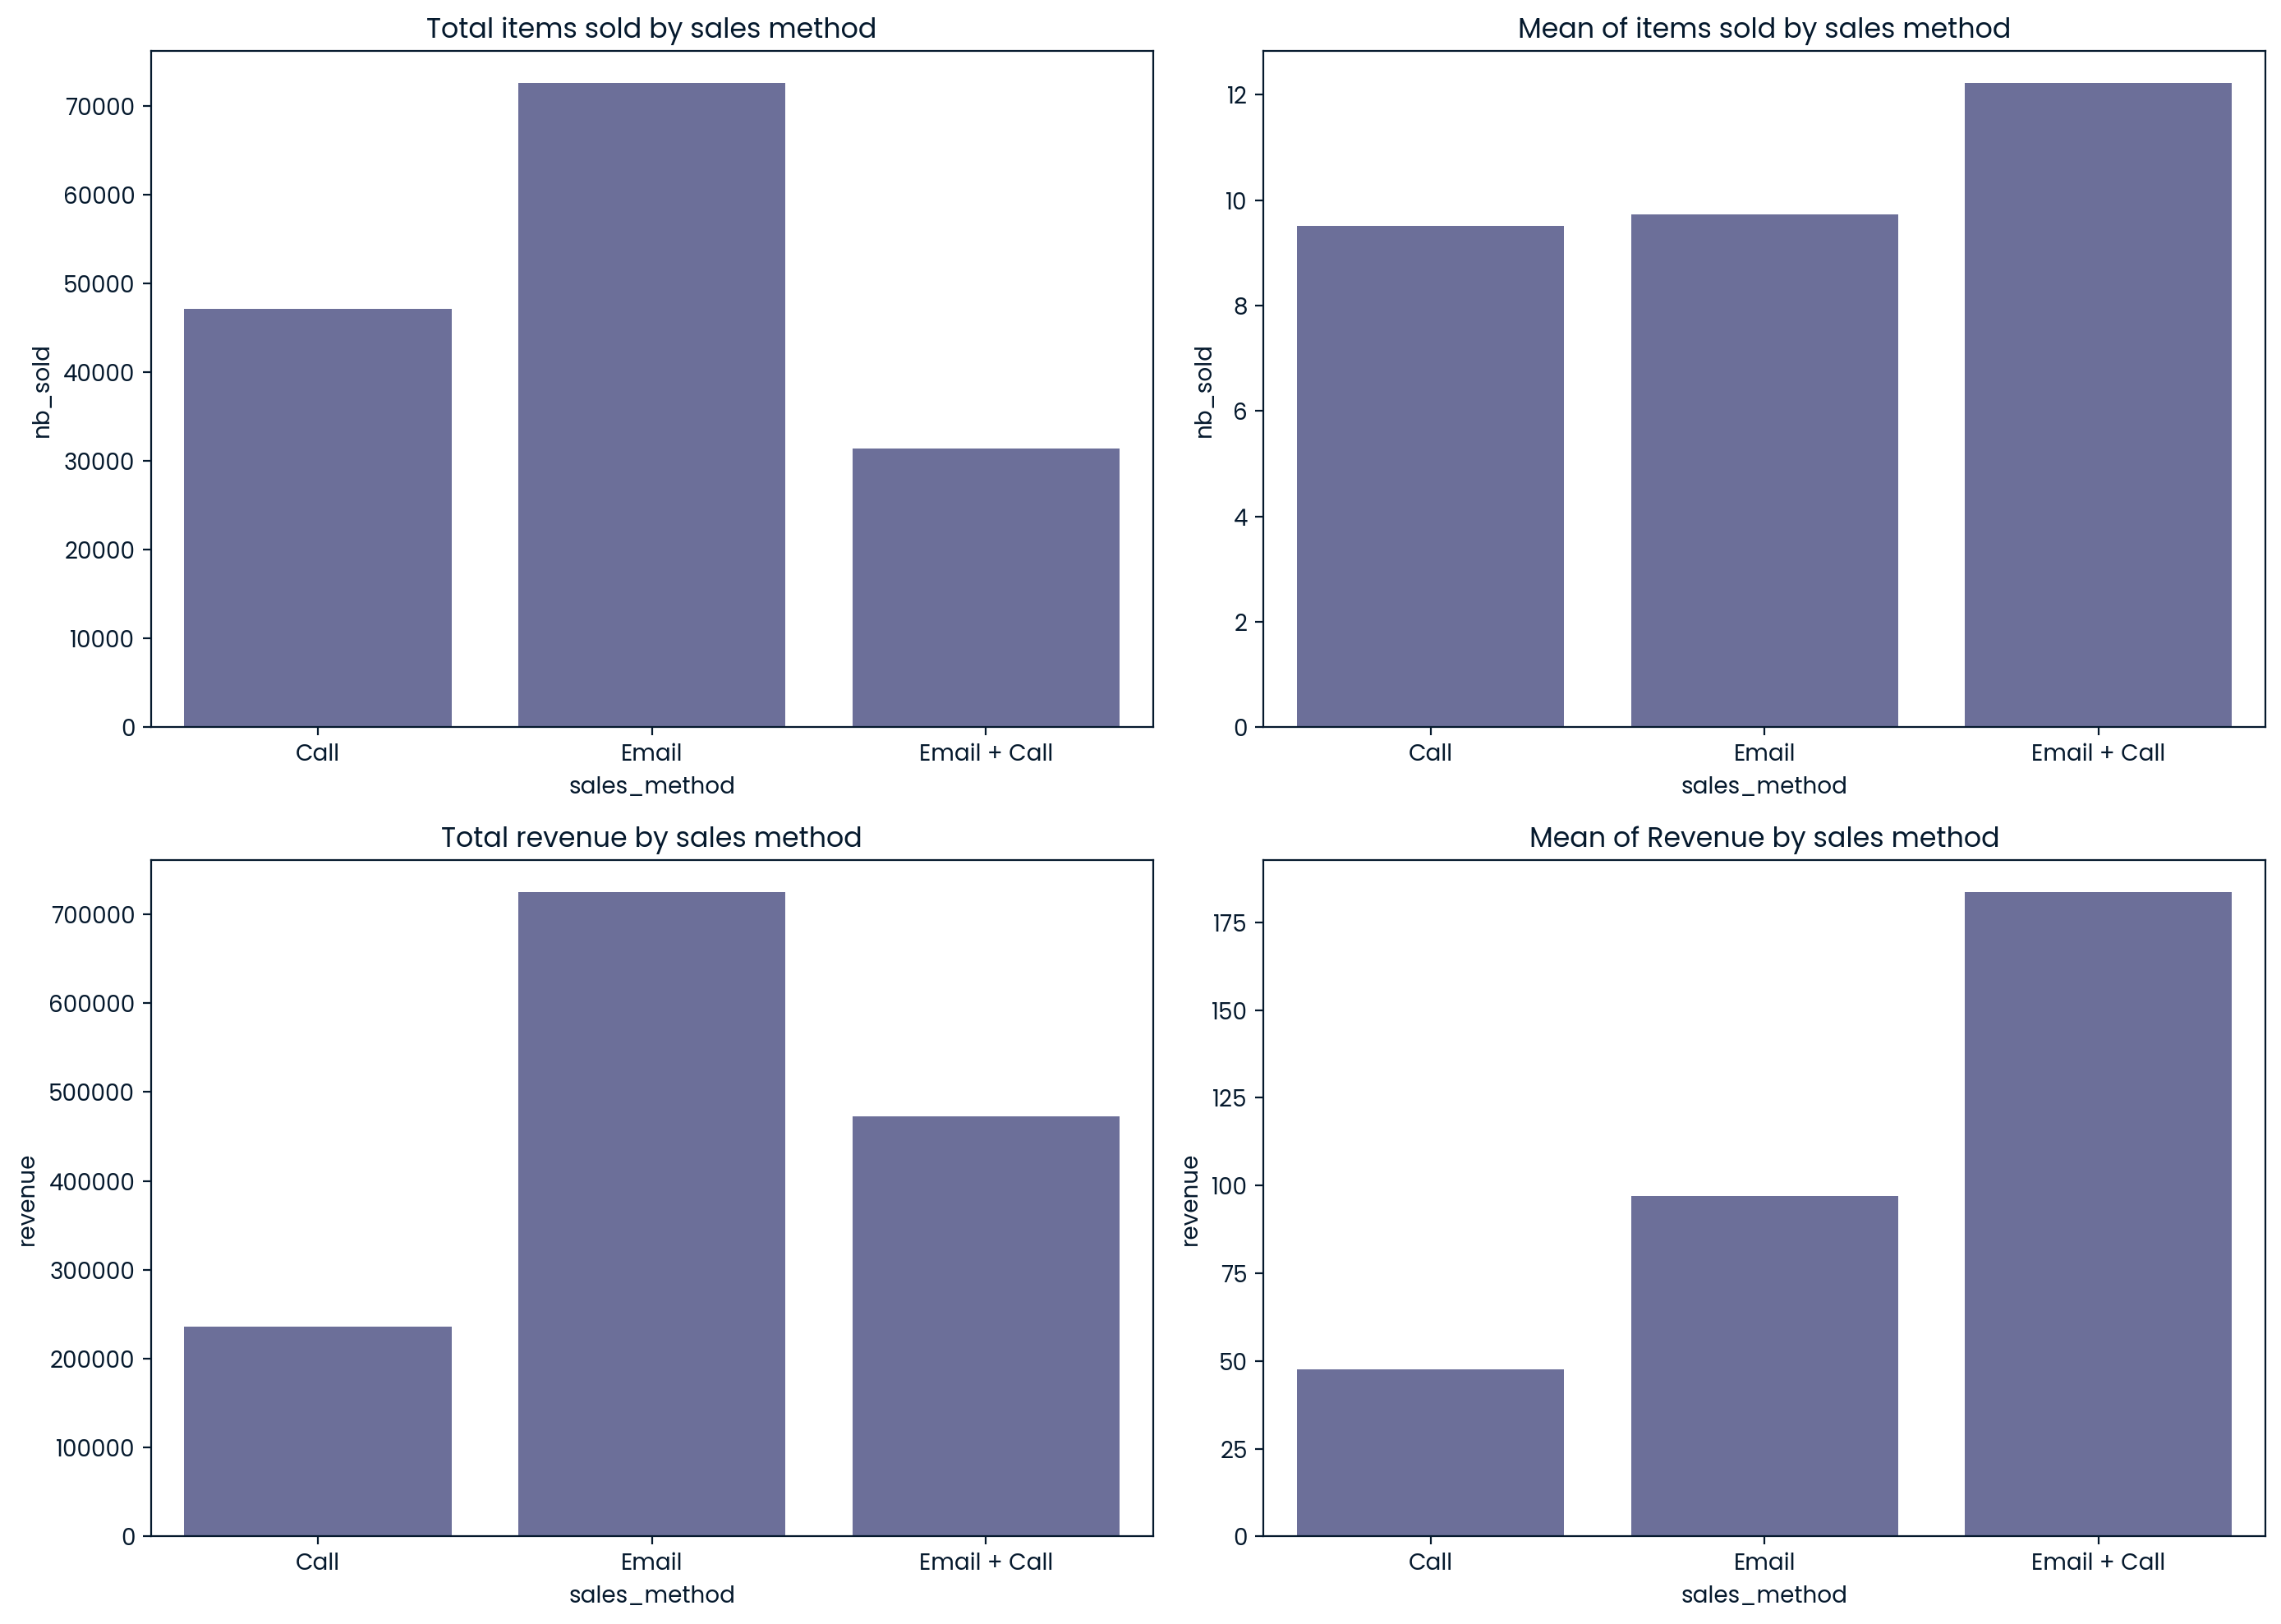

In [19]:
# Calculate sum and mean
df_sum = df.groupby('sales_method').sum().reset_index()
df_mean = df.groupby('sales_method').mean().reset_index()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot sum of revenue by sales method
sns.barplot(ax=axes[0, 0], data=df_sum, x='sales_method', y='nb_sold')
axes[0, 0].set_title('Total items sold by sales method')

# Plot mean of revenue by sales method
sns.barplot(ax=axes[0, 1], data=df_mean, x='sales_method', y='nb_sold')
axes[0, 1].set_title('Mean of items sold by sales method')

# Plot sum of revenue by sales method
sns.barplot(ax=axes[1, 0], data=df_sum, x='sales_method', y='revenue')
axes[1, 0].set_title('Total revenue by sales method')

# Plot mean of revenue by sales method
sns.barplot(ax=axes[1, 1], data=df_mean, x='sales_method', y='revenue')
axes[1, 1].set_title('Mean of Revenue by sales method')


# Show plot
plt.tight_layout()
plt.show()

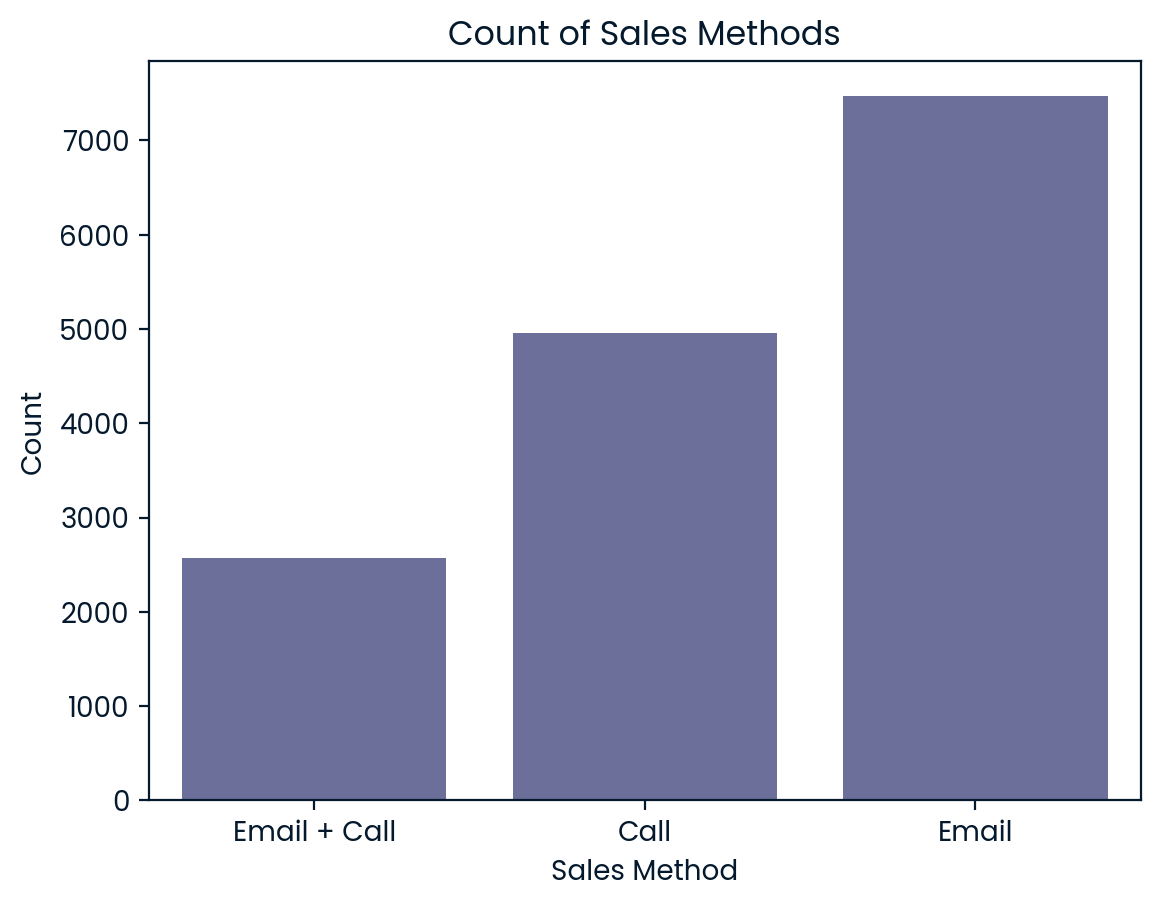

In [20]:
custom_order = ['Email + Call', 'Call', 'Email']

sns.countplot(data=df, x='sales_method', order=custom_order)
plt.title('Count of Sales Methods')
plt.xlabel('Sales Method')
plt.ylabel('Count')
plt.show()

So, with the help of the table, grouped_data, and graphic above, we can already answer the first question of the sales representative. There were **2572** customers reached by the "Email + Call" method, **4962** customers reached by the "Call" method, and **7466** customers reached by the "Email" method.

Now let's consider the time spend for each method. We will assume that sending a mail to the customer took a sales agent 2.5 min and since it send twice, the overrall time spend for one customer using "Email" method was about 5 min. And regarding two other methods sales rep alredy told us that it was 30 min for the "Call" method and 12.5 min for the "Email + Call" method assuming the stated above regarding 2.5 min per mail.

In [21]:
time_spent = {'Call':30, 'Email':5, 'Email + Call':12.5}
grouped_data['time_spent'] = pd.Series(time_spent)
grouped_data['total_time_spent'] = grouped_data['customer_id']['count'] * grouped_data['time_spent']

In [22]:
# Print all columns using to_string
print(grouped_data.to_string())

                nb_sold            revenue            customer_id time_spent total_time_spent
                   mean    sum        mean        sum       count                            
sales_method                                                                                 
Call           9.509674  47187   47.597559  236179.09        4962       30.0         148860.0
Email          9.729306  72639   97.127853  725156.55        7466        5.0          37330.0
Email + Call  12.225505  31444  183.651065  472350.54        2572       12.5          32150.0


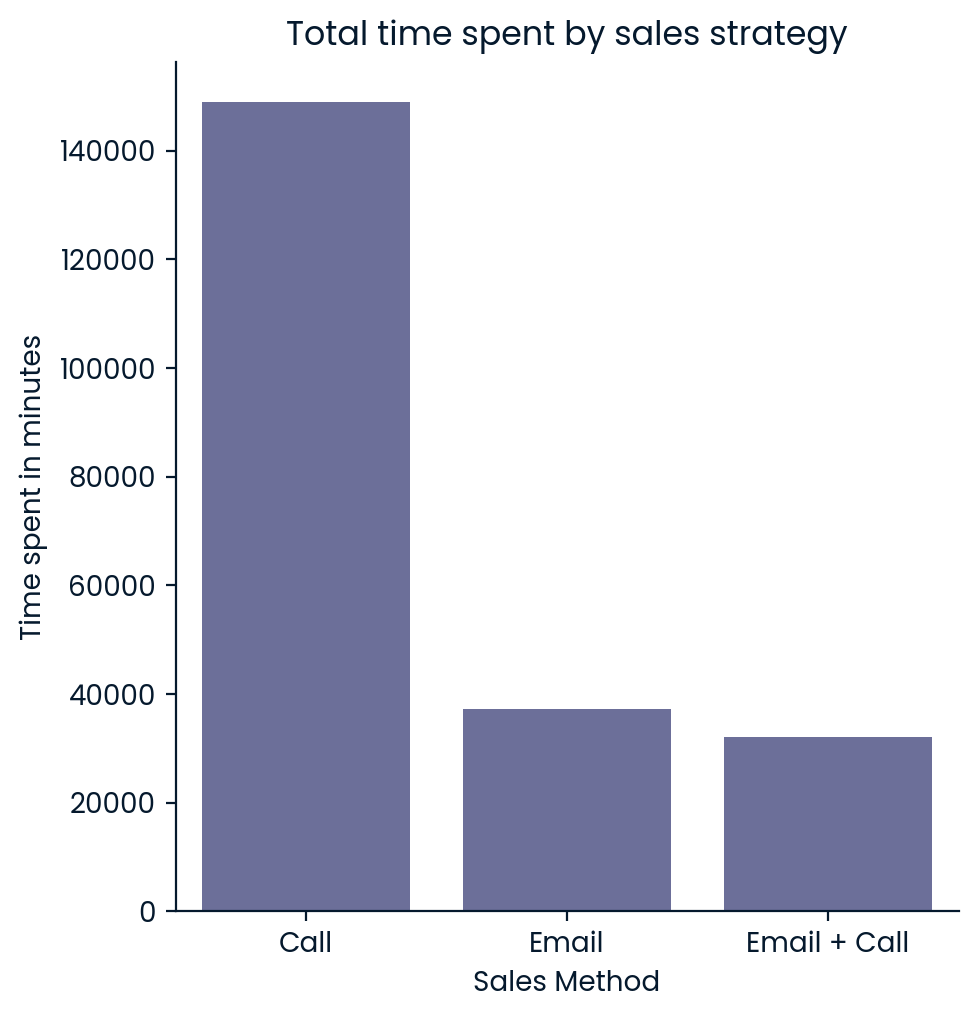

In [23]:
sns.catplot(data=grouped_data, x='sales_method', y='total_time_spent', kind='bar')
plt.title('Total time spent by sales strategy')
plt.xlabel('Sales Method')
plt.ylabel('Time spent in minutes')
plt.show()

In [24]:
print(grouped_data.total_time_spent / 60 / 24)

sales_method
Call            103.375000
Email            25.923611
Email + Call     22.326389
Name: total_time_spent, dtype: float64


We observe that the "Call" sales method took significantly longer than the other two methods. However, it was the least effective strategy in terms of total revenue. The "Email" and "Email + Call" sales methods took nearly the same amount of time, but it's important to note that in the "Email" strategy there were more customers.

If we convert those minutes into days, we will see that the time spent by our agents speaking with customers on the phone was equal to 103 days, and only 26 and 22 days for the "Email" and "Email + Call" sales methods, respectively.

Now, let's examine the overall revenue spread.

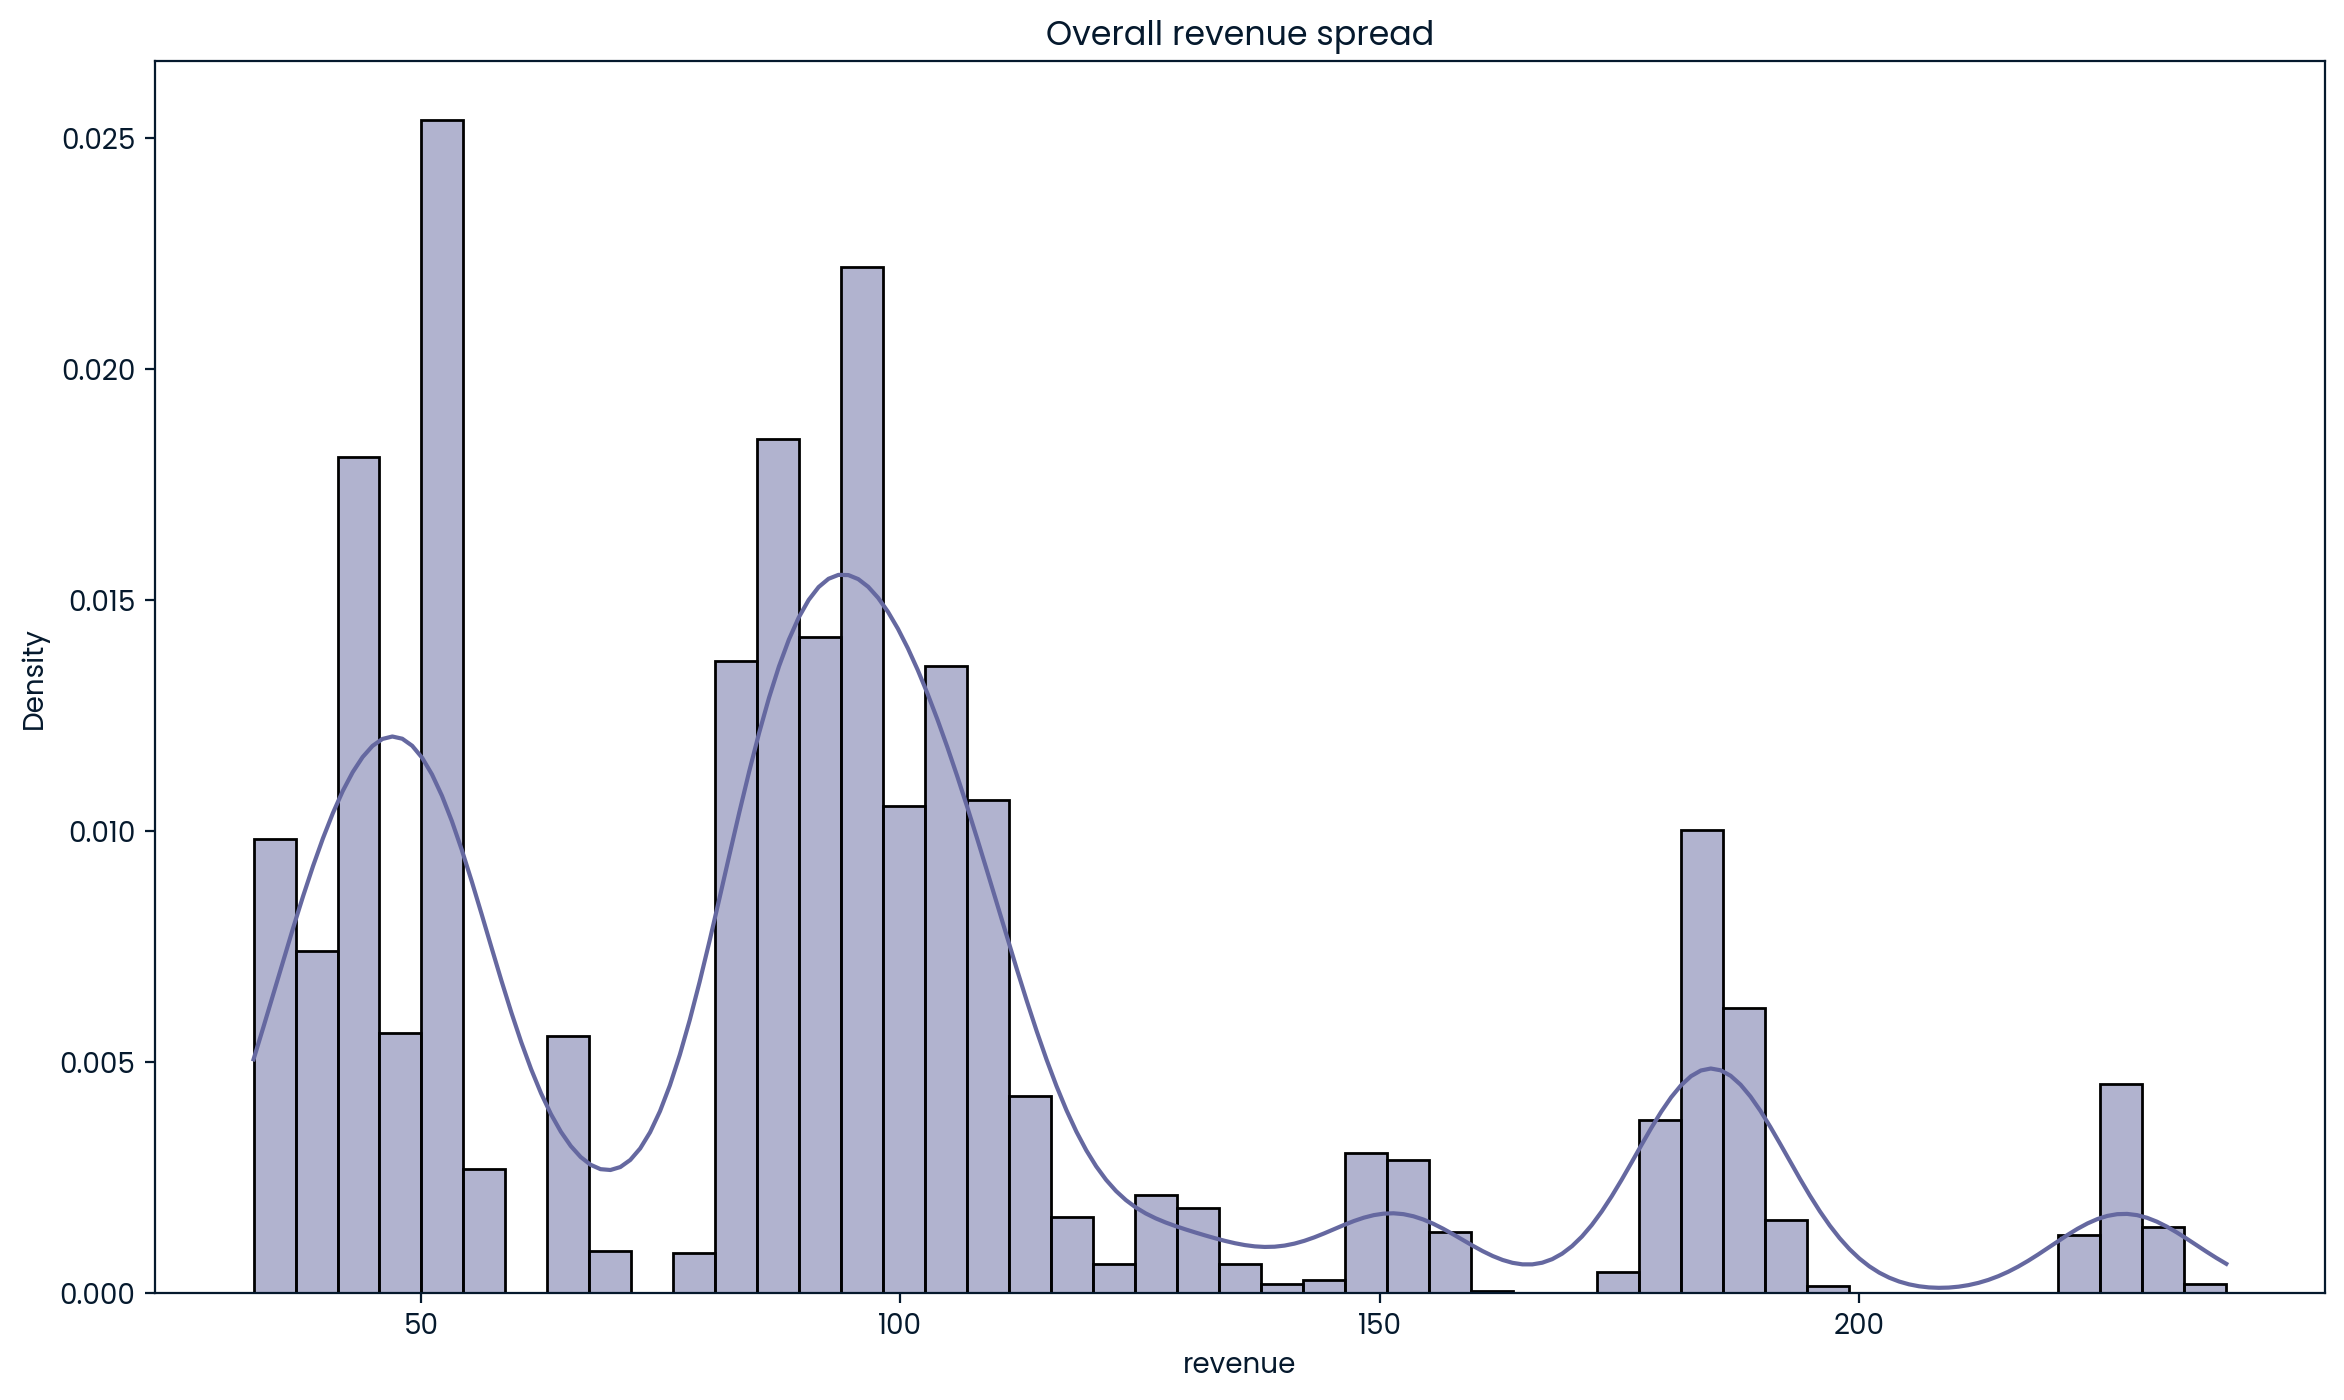

In [25]:
plt.figure(figsize=(14, 8))
sns.histplot(df.revenue, kde=True, stat='density')
plt.title('Overall revenue spread')
plt.show()

Based on the graph, it's clear that the distribution does not follow a normal pattern. Therefore, we will try to visually represent the revenue spread of each method to determine if any of them exhibit a normal distribution. This will allow us to compare them analytically.

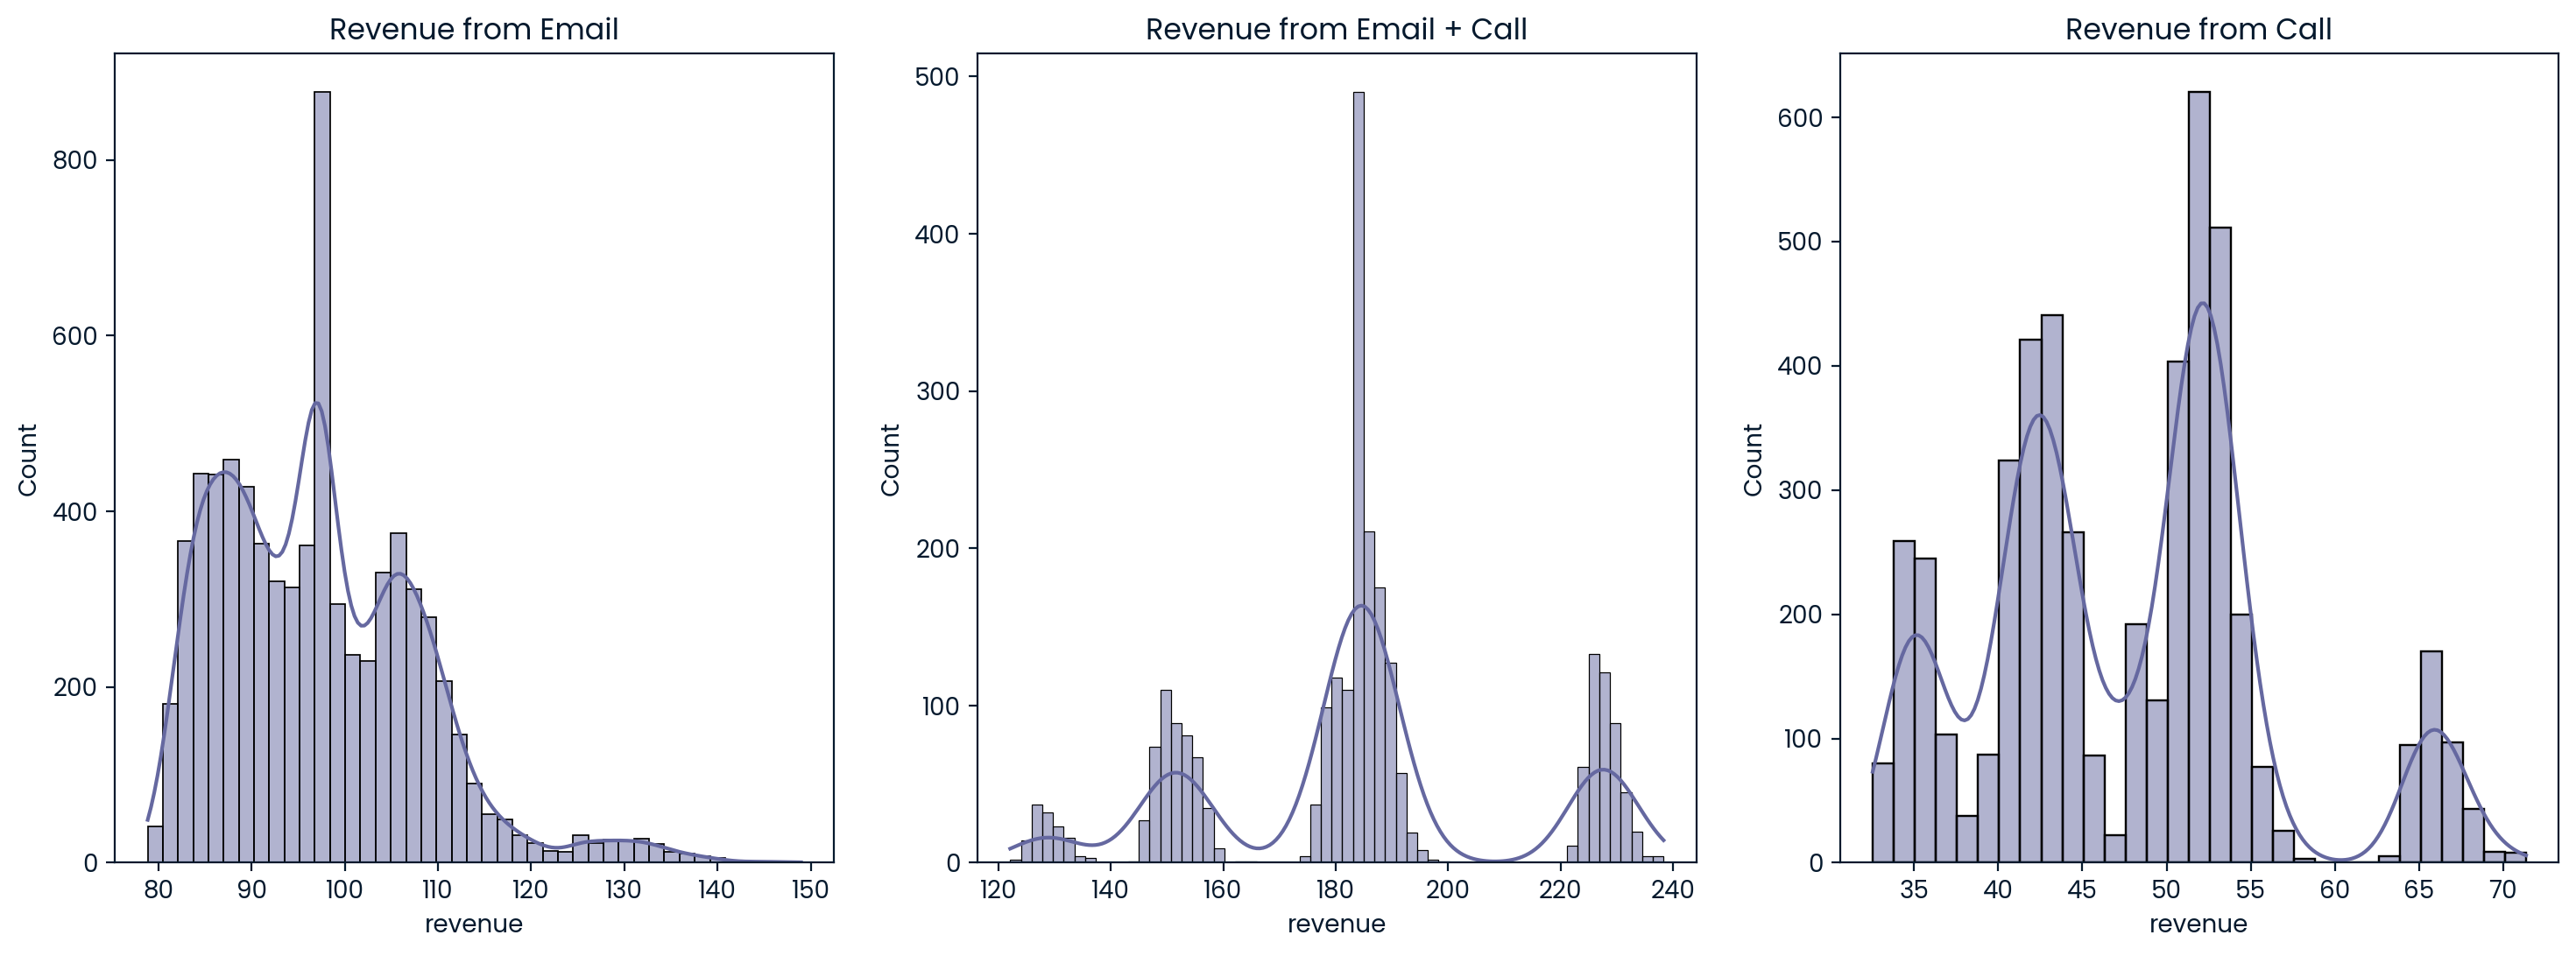

In [26]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# First histogram
sns.histplot(ax=axes[0], data=df[df.sales_method == 'Email'].revenue, kde=True)
axes[0].set_title('Revenue from Email')

# Second histogram
sns.histplot(ax=axes[1], data=df[df.sales_method == 'Email + Call'].revenue, kde=True)
axes[1].set_title('Revenue from Email + Call')

# Third histogram
sns.histplot(ax=axes[2], data=df[df.sales_method == 'Call'].revenue, kde=True)
axes[2].set_title('Revenue from Call')

plt.show()

Looking at these plots, we observe that the revenue does not seem to follow a normal distribution. Let's plot the revenue of each method next to each other using a violin plot to compare them and gain a better understanding.

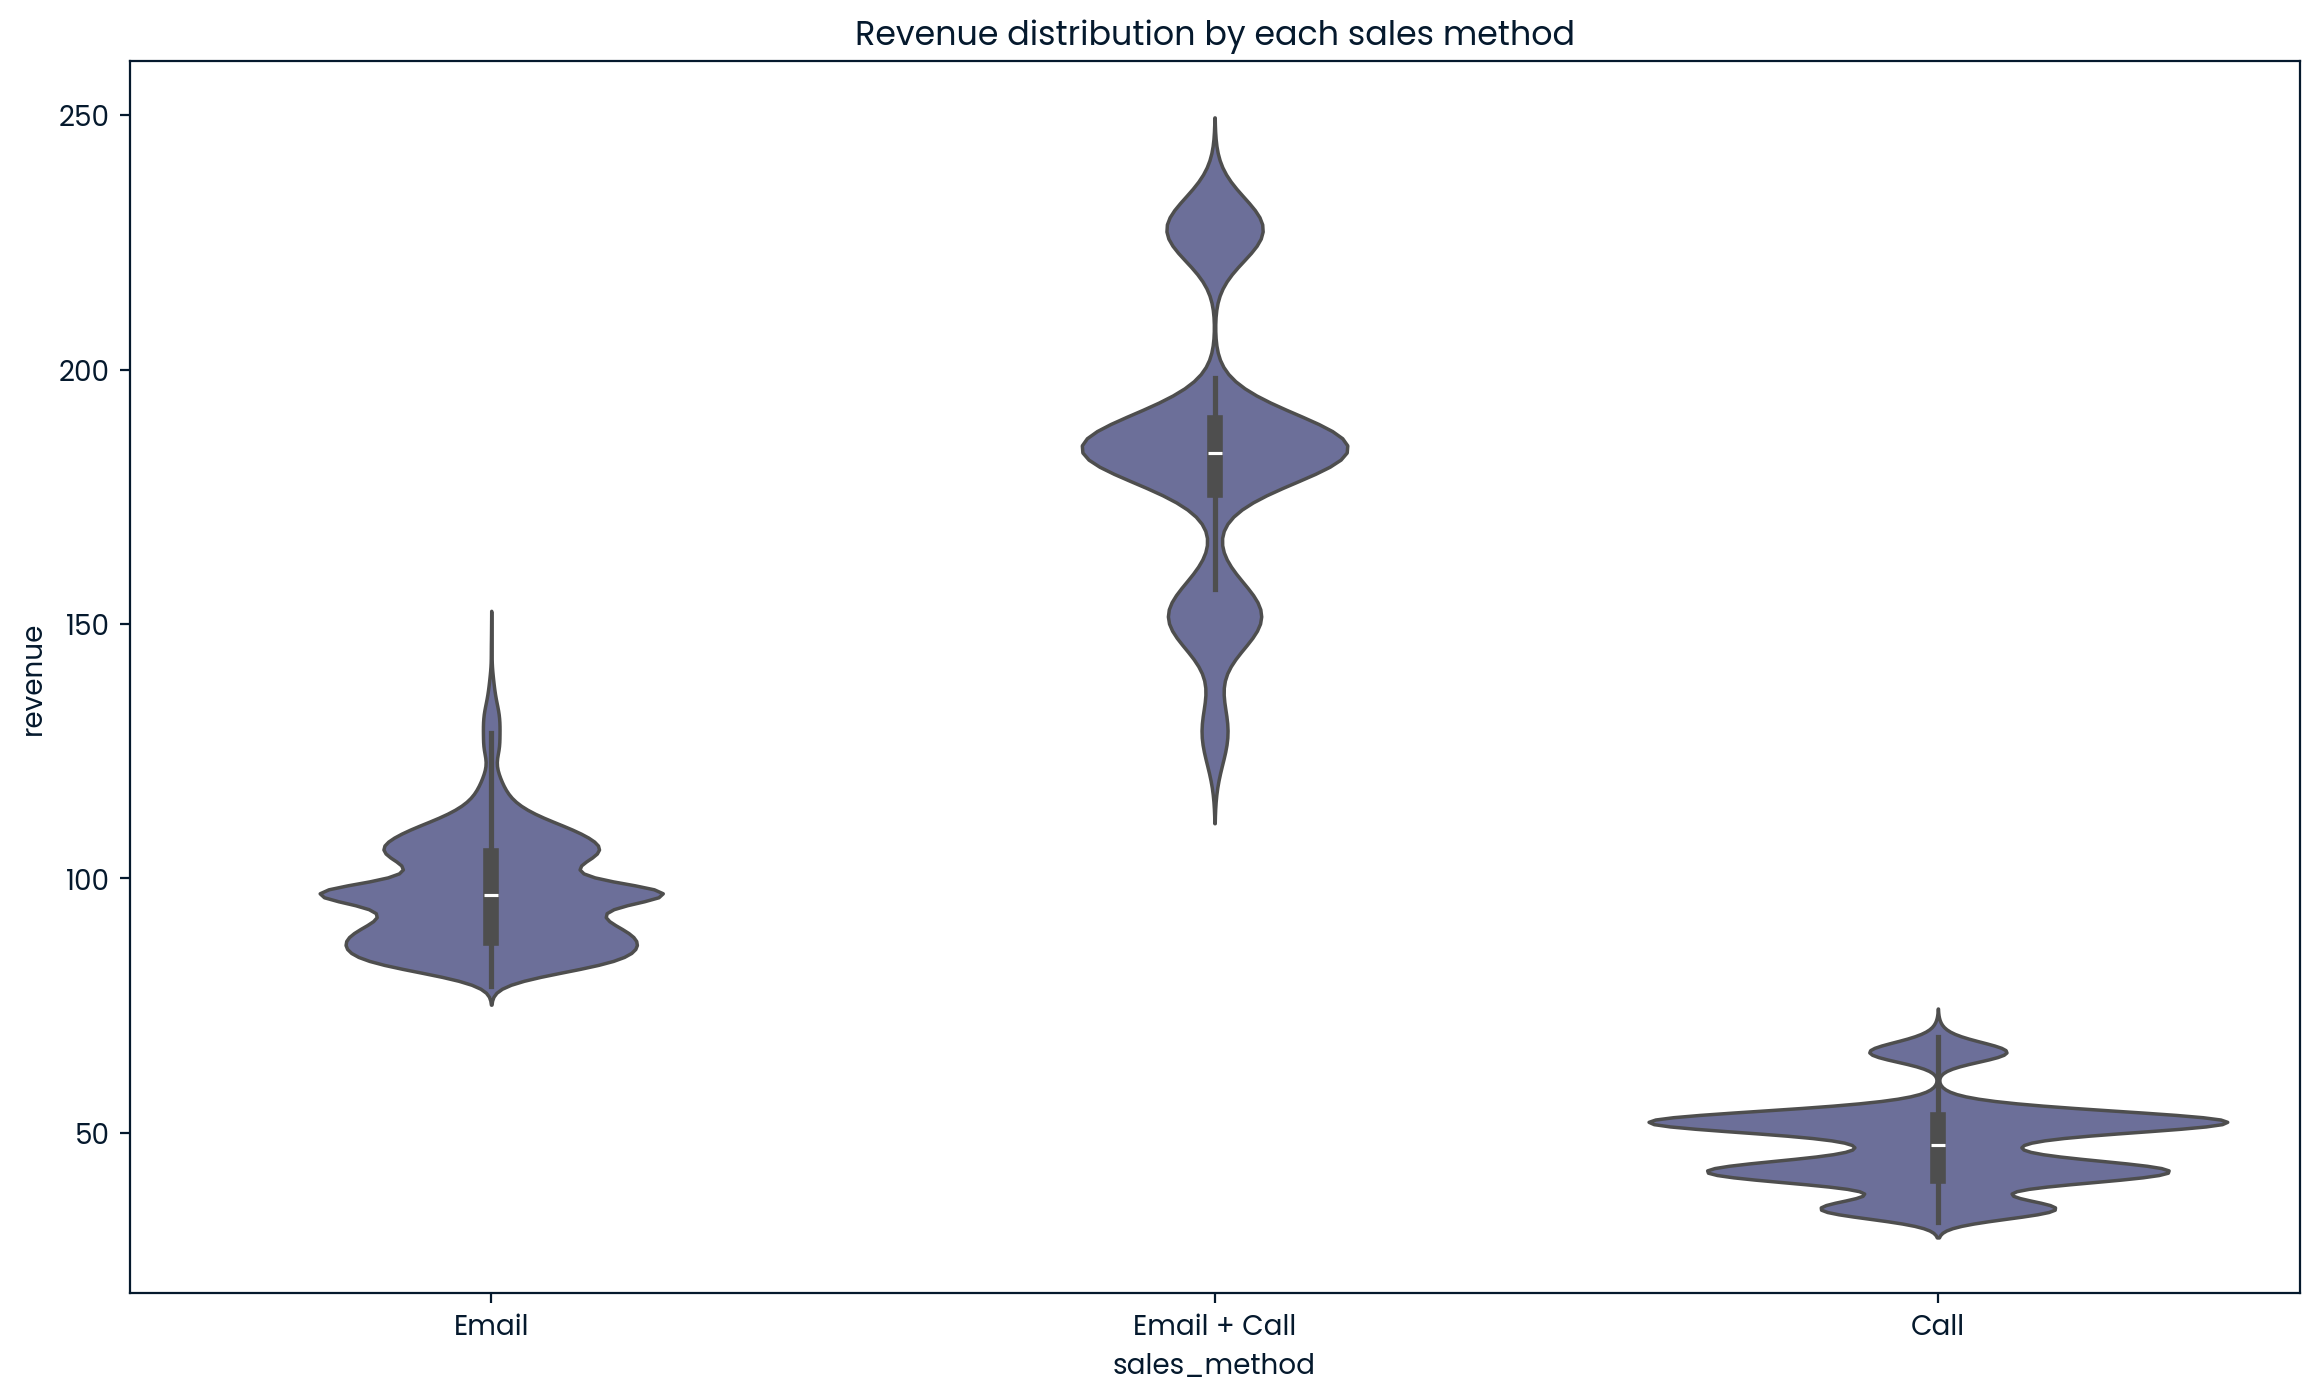

In [27]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='sales_method', y='revenue')
plt.title('Revenue distribution by each sales method')
plt.show()

We already have strong evidence that the "Email + Call" strategy has the best performance in terms of revenue, while the "Call" method has the worst performance. We will use ANOVA and Tukey-HSD tests to obtain numerical confirmation. First, we will perform a Shapiro-Wilk test and use a QQ plot to confirm whether our data is normally distributed. If it is not, we will need to resort to the central limit theorem to produce normally distributed data.

In [28]:
email = df[df.sales_method == 'Email'].revenue
email_call = df[df.sales_method == 'Email + Call'].revenue
call = df[df.sales_method == 'Call'].revenue

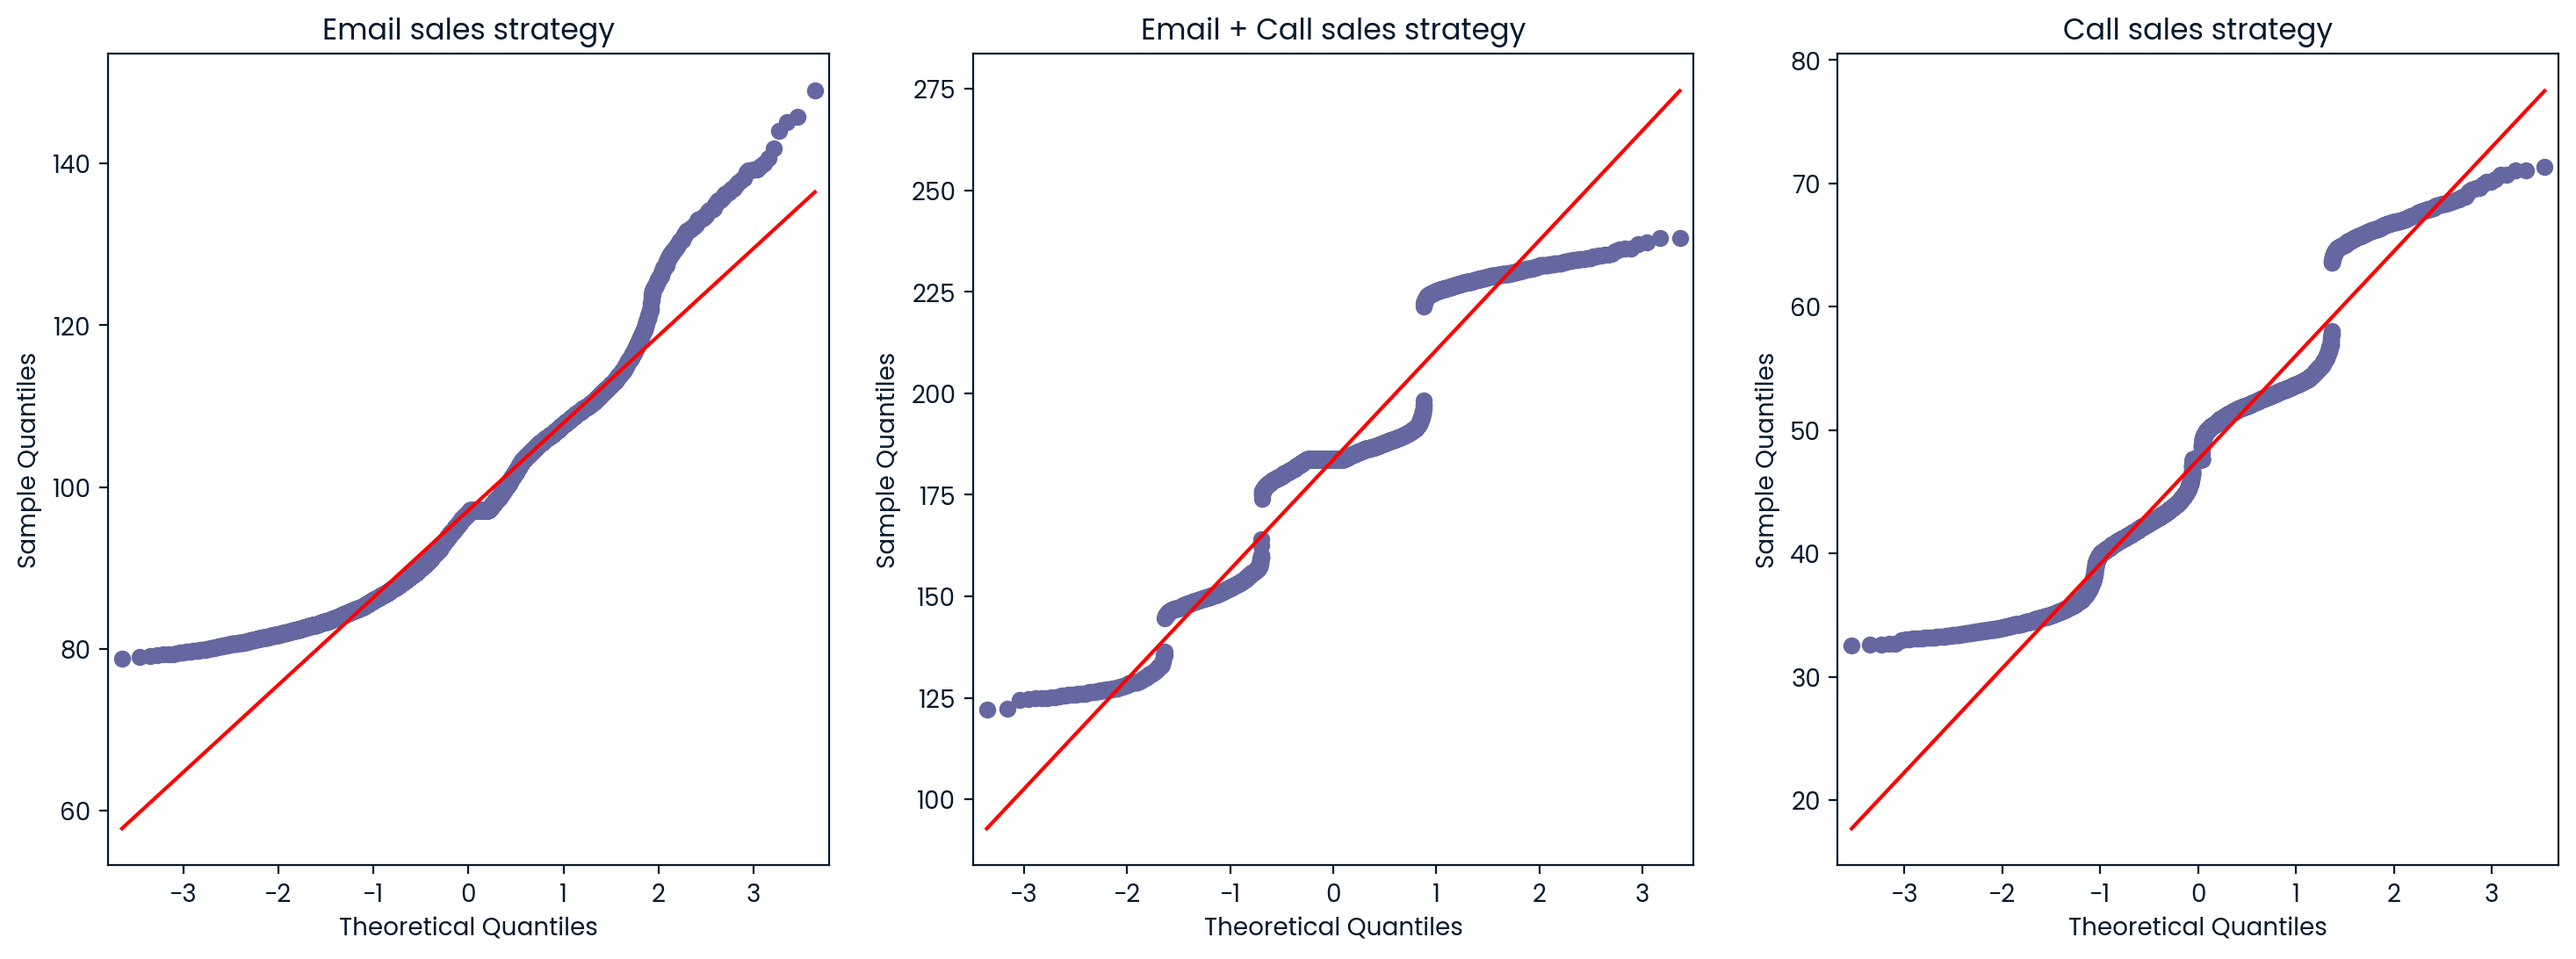

In [29]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First qqplot
qqplot(email, ax=axes[0],   line='s',  dist=norm)
axes[0].set_title('Email sales strategy')

# Second qqplot
qqplot(email_call, ax=axes[1],  line='s',  dist=norm)
axes[1].set_title('Email + Call sales strategy')

# Third qqplot
qqplot(call, ax=axes[2],  line='s',  dist=norm)
axes[2].set_title('Call sales strategy')

plt.show()

In [30]:
alpha = 0.05  
stat_e, p_e = shapiro(email) 
stat_ec, p_ec = shapiro(email_call) 
stat_c, p_c = shapiro(call) 
print(f"Email: p = {(p_e)} test stat: {round(stat_e,4)}")
print(f"Email + Call: p = {p_ec} test stat: {round(stat_ec,4)}")
print(f"Call: p =  {p_c} test stat: {round(stat_c,4)}")


Email: p = 1.401298464324817e-45 test stat: 0.9474
Email + Call: p = 5.863481638659127e-37 test stat: 0.9074
Call: p =  5.903922663924033e-39 test stat: 0.9472


Based on the charts and the low p-values for each sales strategy, we reject the null hypothesis that the data is normally distributed and confirm that our distributions are not normal. 

Next, we will use the central limit theorem to create normally distributed data. Because our samples for each method contain more than 30 different values, we do not have to worry that the central limit theorem will be invalid. 

In [31]:
# Set random seed for repeatability  
np.random.seed(47) 

# Create dictionaries to hold the sampled means for each group
sampled_means = {'email': [], 'email_call': [], 'call': []}

# Number of samples and sample size
n_samples = 10000
sample_size = 500

# List of groups
groups = [email, email_call, call]
group_names = ['email', 'email_call', 'call']

# Loop through each group
for group, name in zip(groups, group_names):
    for i in range(n_samples):
        # Take a sample with replacement
        sample = group.sample(sample_size, replace=True)
        # Calculate the sample mean and append to the list for the current group
        sample_mean = np.mean(sample)
        sampled_means[name].append(sample_mean)

# Convert the dictionary to a DataFrame for easier analysis and visualization
sampled_means_df = pd.DataFrame(sampled_means)

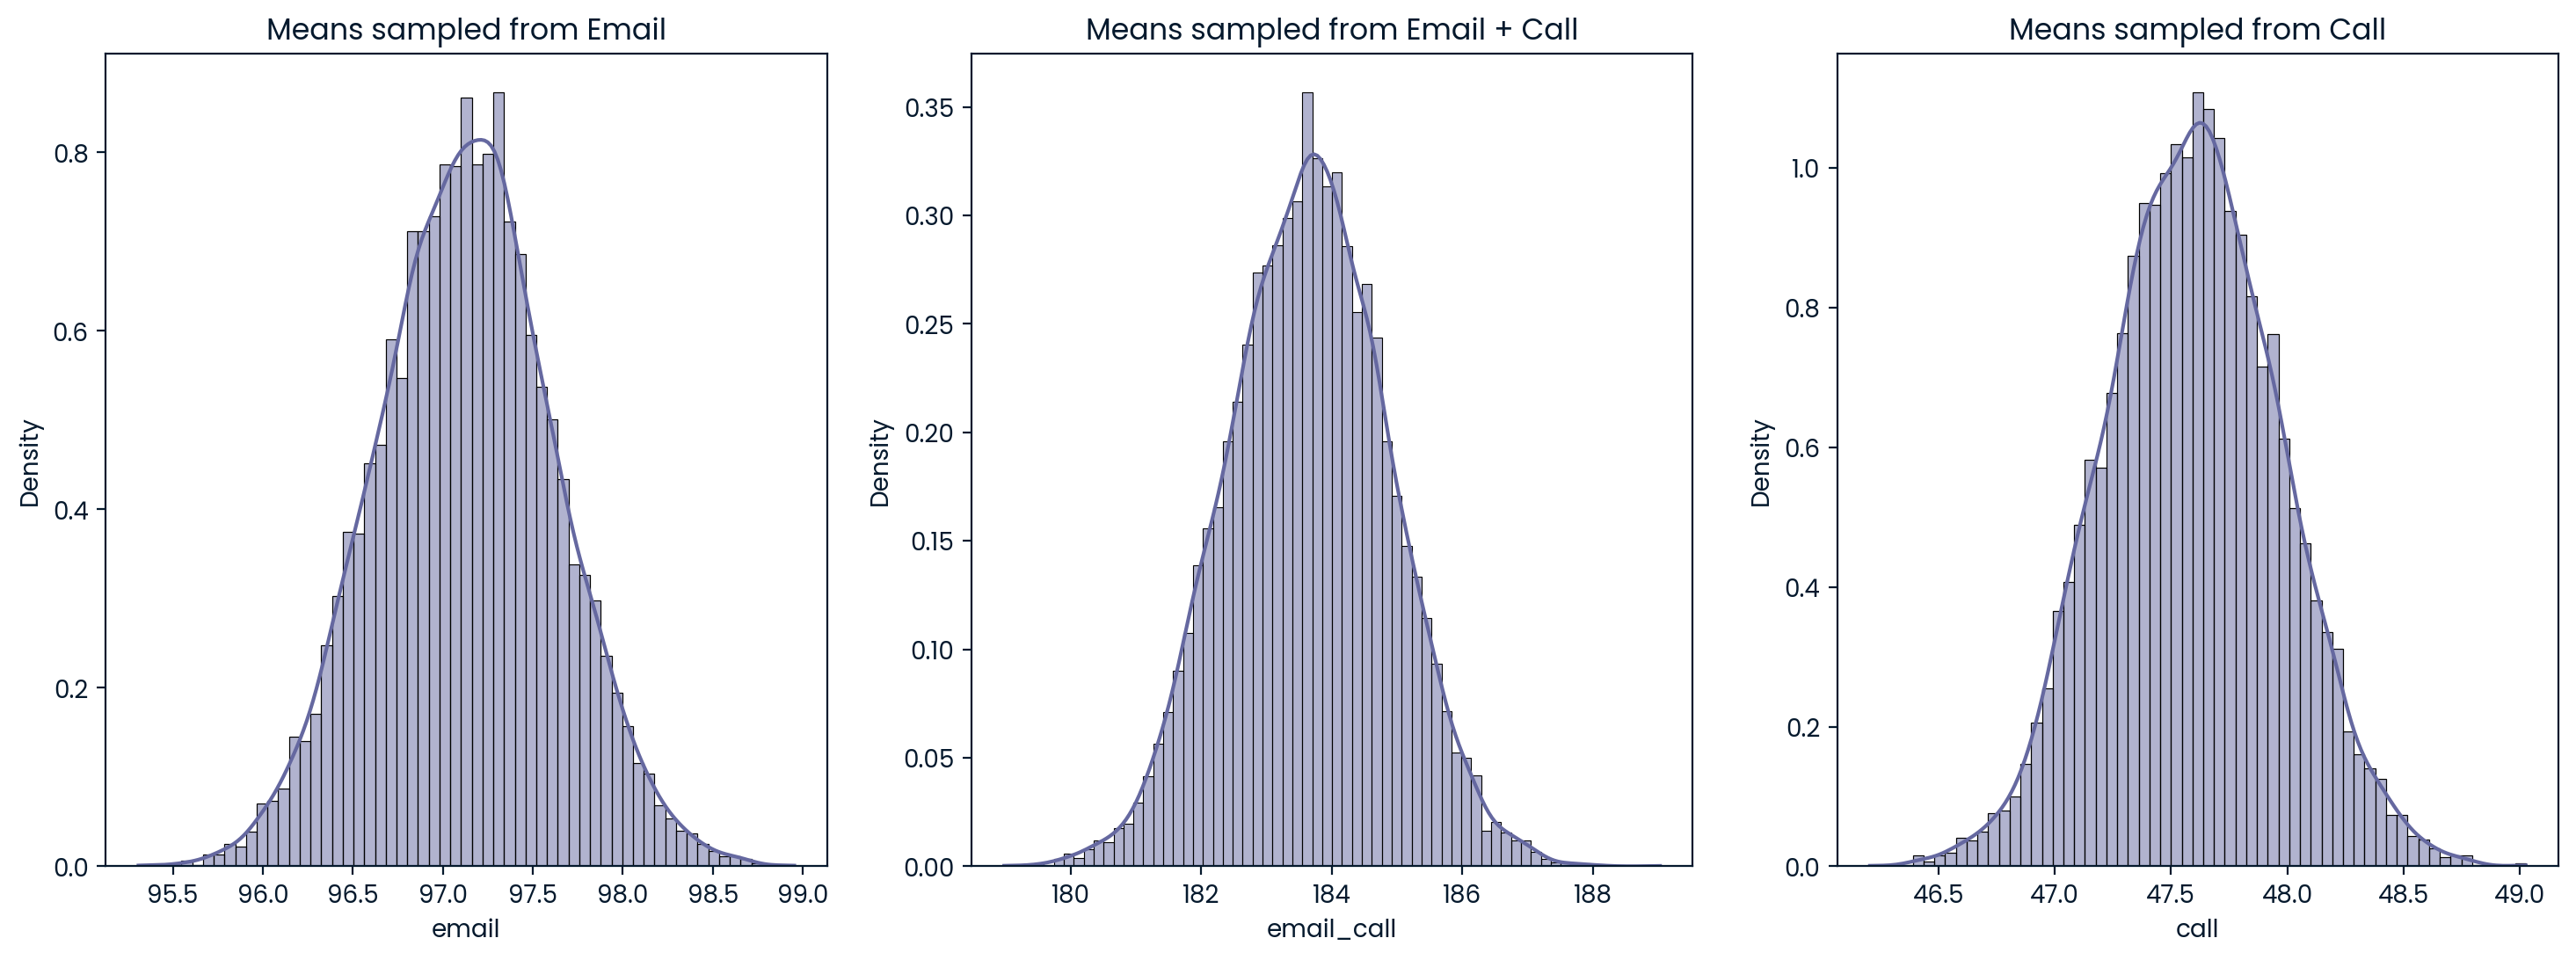

In [32]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# First histogram
sns.histplot(ax=axes[0], data=sampled_means_df.email, kde=True, stat='density')
axes[0].set_title('Means sampled from Email')

# Second histogram
sns.histplot(ax=axes[1], data=sampled_means_df.email_call, kde=True, stat='density')
axes[1].set_title('Means sampled from Email + Call')

# Third histogram
sns.histplot(ax=axes[2], data=sampled_means_df.call, kde=True, stat='density')
axes[2].set_title('Means sampled from Call')

plt.show()

In [33]:
alpha = 0.05  
stat_e, p_e = shapiro(sampled_means_df.email) 
stat_ec, p_ec = shapiro(sampled_means_df.email_call) 
stat_c, p_c = shapiro(sampled_means_df.call) 
print(f"Email: p = {(p_e)} test stat: {round(stat_e,4)}")
print(f"Email + Call: p = {p_ec} test stat: {round(stat_ec,4)}")
print(f"Call: p =  {p_c} test stat: {round(stat_c,4)}")

Email: p = 0.7550672888755798 test stat: 0.9998
Email + Call: p = 0.8849138021469116 test stat: 0.9999
Call: p =  0.3498672842979431 test stat: 0.9998


We observed that all three histograms resemble a normal distribution. After performing the Shapiro-Wilk test, we found that the p-values are greater than 0.05, indicating that we fail to reject the null hypothesis of normality. 

With normally distributed data, we can proceed to use the ANOVA test to determine if there are significant differences among the three methods. If the ANOVA test reveals significant differences, we will then perform a post-hoc test to identify which specific methods differ from each other

In [34]:
# Perform the one-way ANOVA
f_stat, p_val = f_oneway(sampled_means_df.email, sampled_means_df.email_call, sampled_means_df.call)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

F-statistic: 75893905.33925734
P-value: 0.0


The ANOVA test confirmed that at least one group is different from the other two. The small p-value and large F-statistic indicate that we can reject the null hypothesis, which states that all groups have similar means.


In [35]:
# Melt the DataFrame to long format
melted_df = pd.melt(sampled_means_df, var_name='groups', value_name='endog')

# Extract endog (sample means) and groups (group labels)
endog = melted_df['endog'].values
groups = melted_df['groups'].values

tukey_results = pairwise_tukeyhsd(endog, groups)
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1   group2   meandiff p-adj  lower    upper   reject
---------------------------------------------------------
  call      email  49.5343   0.0  49.5081  49.5605   True
  call email_call 136.0514   0.0 136.0252 136.0776   True
 email email_call  86.5171   0.0  86.4909  86.5433   True
---------------------------------------------------------


Based on the data and the results of Tukey's HSD test, there are statistically significant differences in means between all pairs of groups (call vs email, call vs email_call, and email vs email_call). The positive mean difference values suggest that, on average, the revenues associated with email, email_call, and email_call are higher than those associated with a call.

After analyzing the distribution of each sales strategy, we can study the effect of other variables. We will start by generating a correlation matrix to see if there are any strong correlations.

In [36]:
corr_matrix = df.corr()

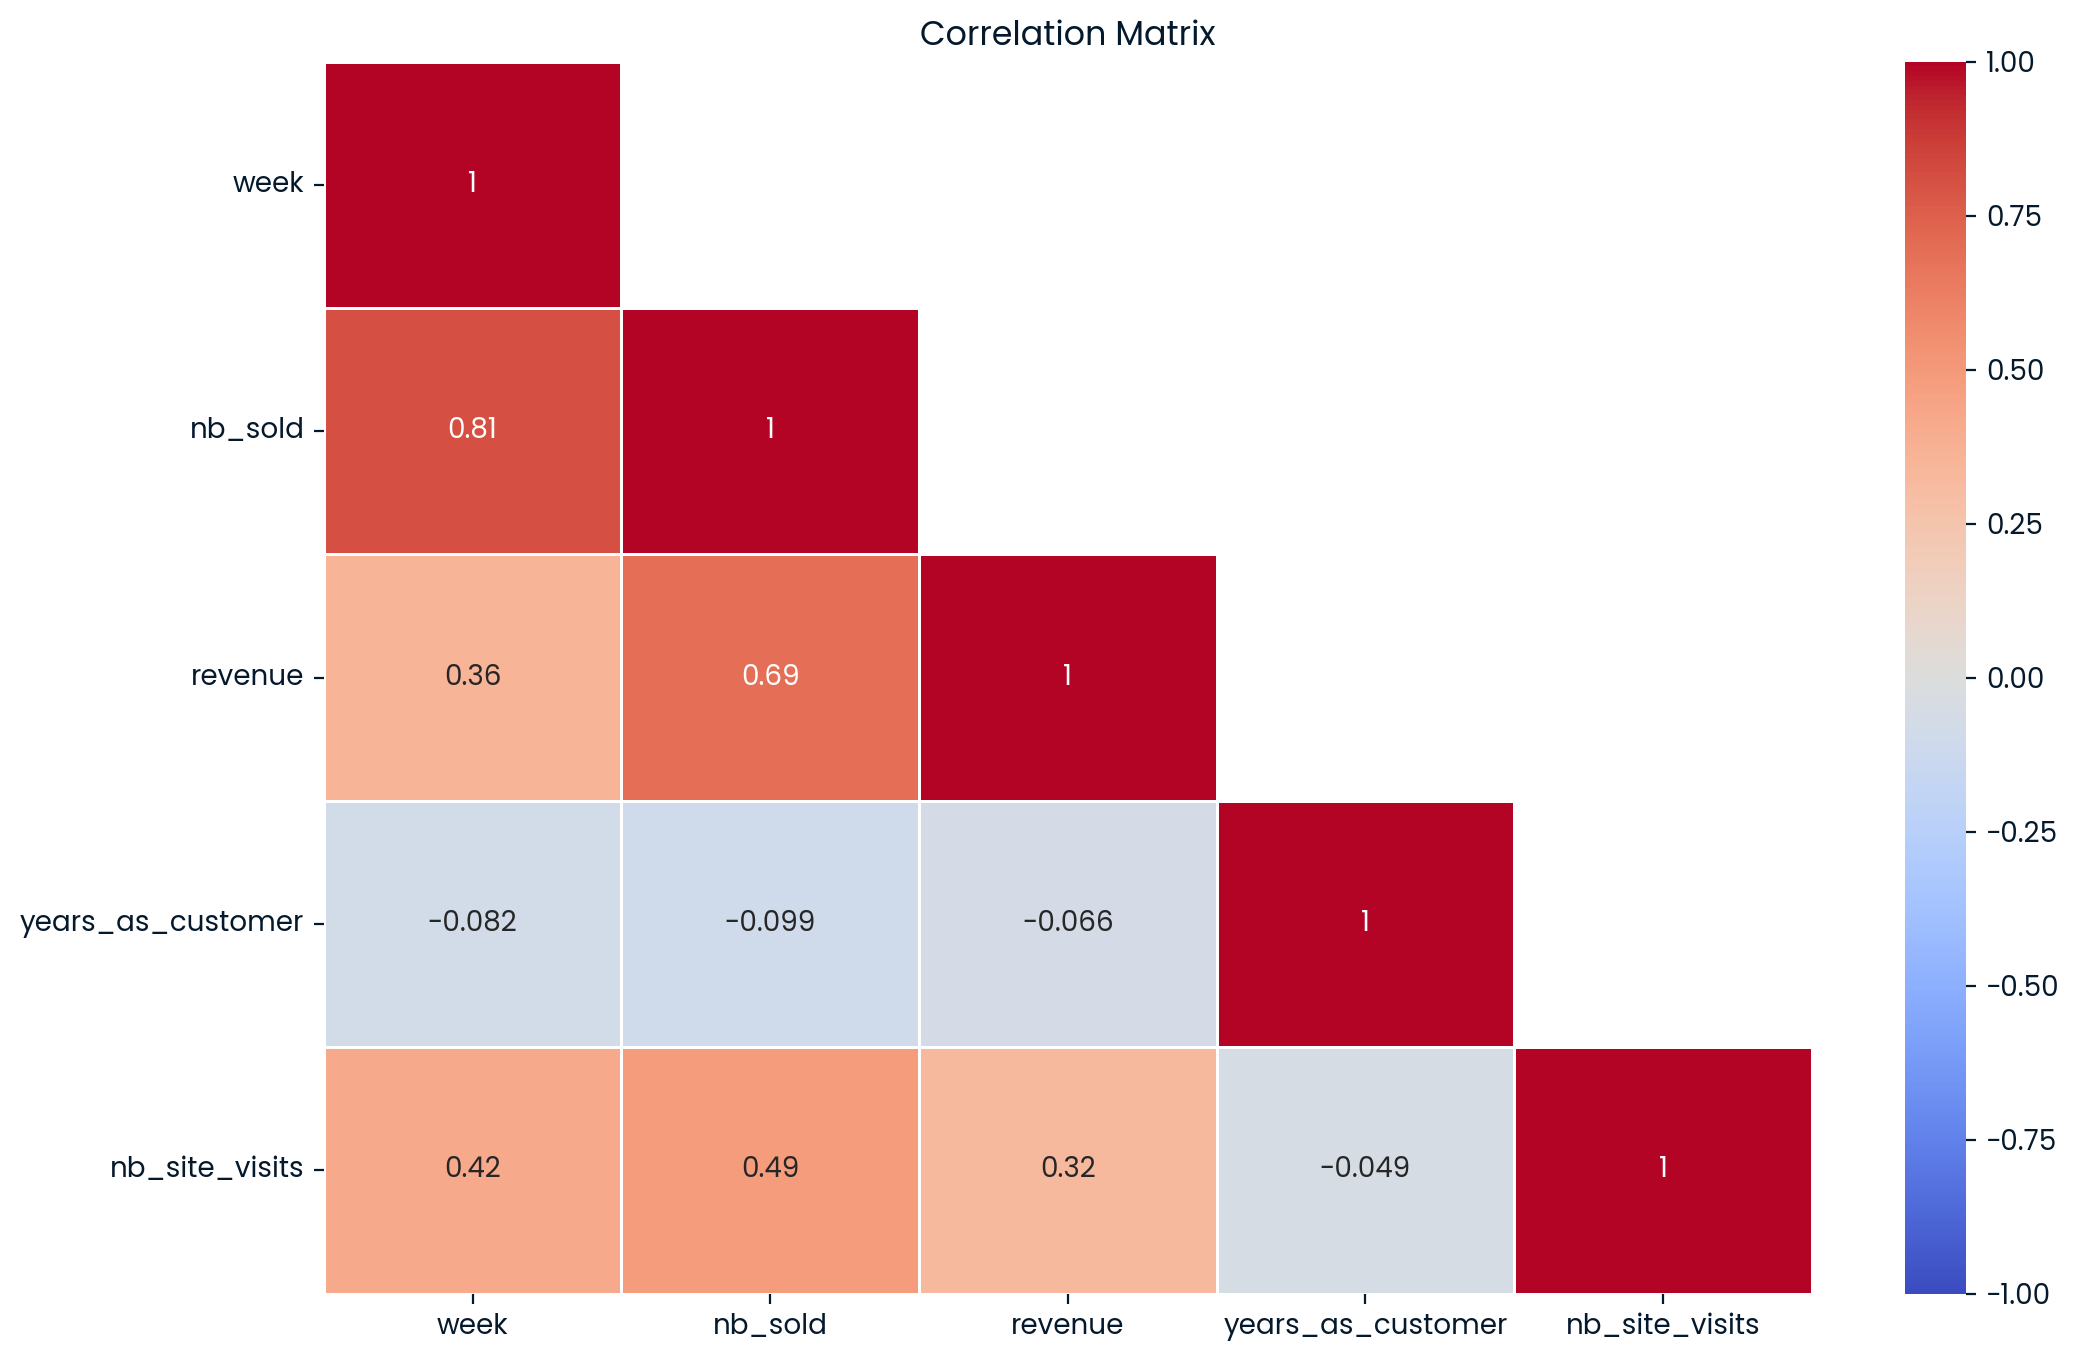

In [37]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, vmin=-1, vmax=1, mask=mask)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title('Correlation Matrix')
plt.show()

After examining the heatmap above, it is clear that there are a few strong correlations between different variables. The most notable correlation is between the number of items sold and the week when the transaction was performed. Unfortunately, since these two variables are categorical with relatively few unique values, it's difficult to interpret the plot. Instead of using the number of items sold, we will focus on revenue, which has a strong correlation with the number of items sold.

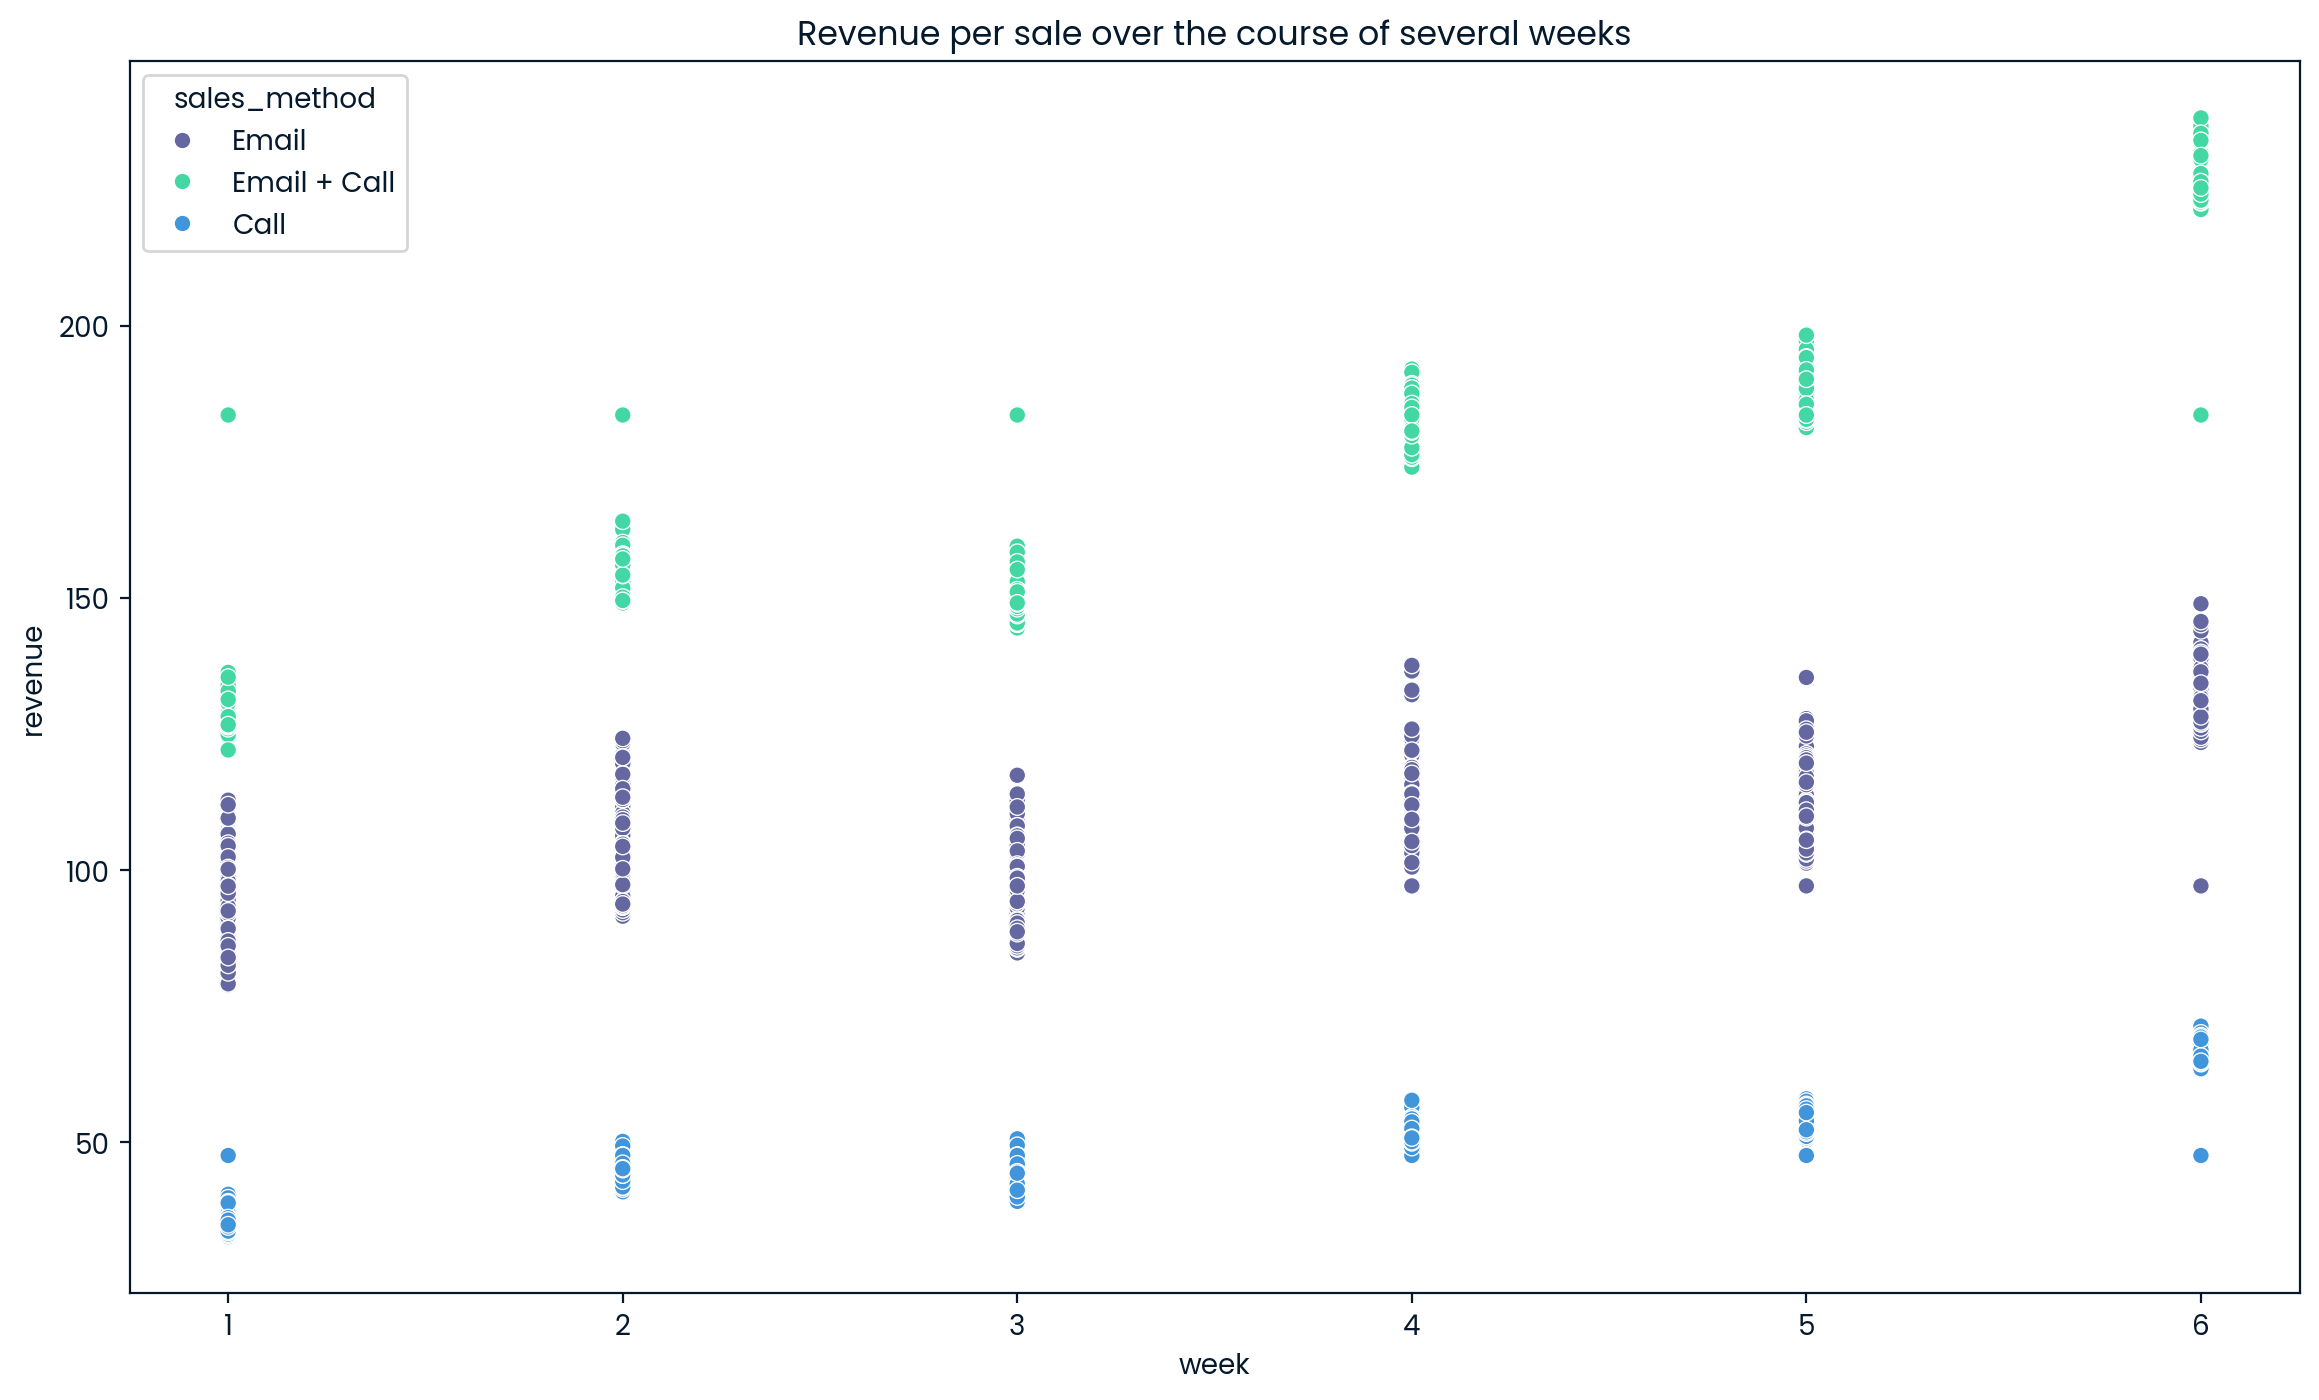

In [38]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='week', y='revenue', hue='sales_method')
plt.title('Revenue per sale over the course of several weeks')
plt.show()

The data shows that the revenue for all three sales methods was increasing. This could be because sales agents gained more experience and began selling more items over time, due to increased prices, or because they became more skilled at selling higher-priced products. Other factors that are determined by experiment include sending an email in the first week and then another one after 3 weeks in the "Email" group. A similar factor occurs in the "Email + Call" group, with a one-week delay between sending the email and making the phone call. It's likely that a combination of these factors plays a role.

Additionally, the graph illustrates the performance of the three sales strategies, confirming that "Email + Call" was the most successful strategy.

The outliers observed in the "Email + Call" group are a result of the mean value we used to fill in missing data.

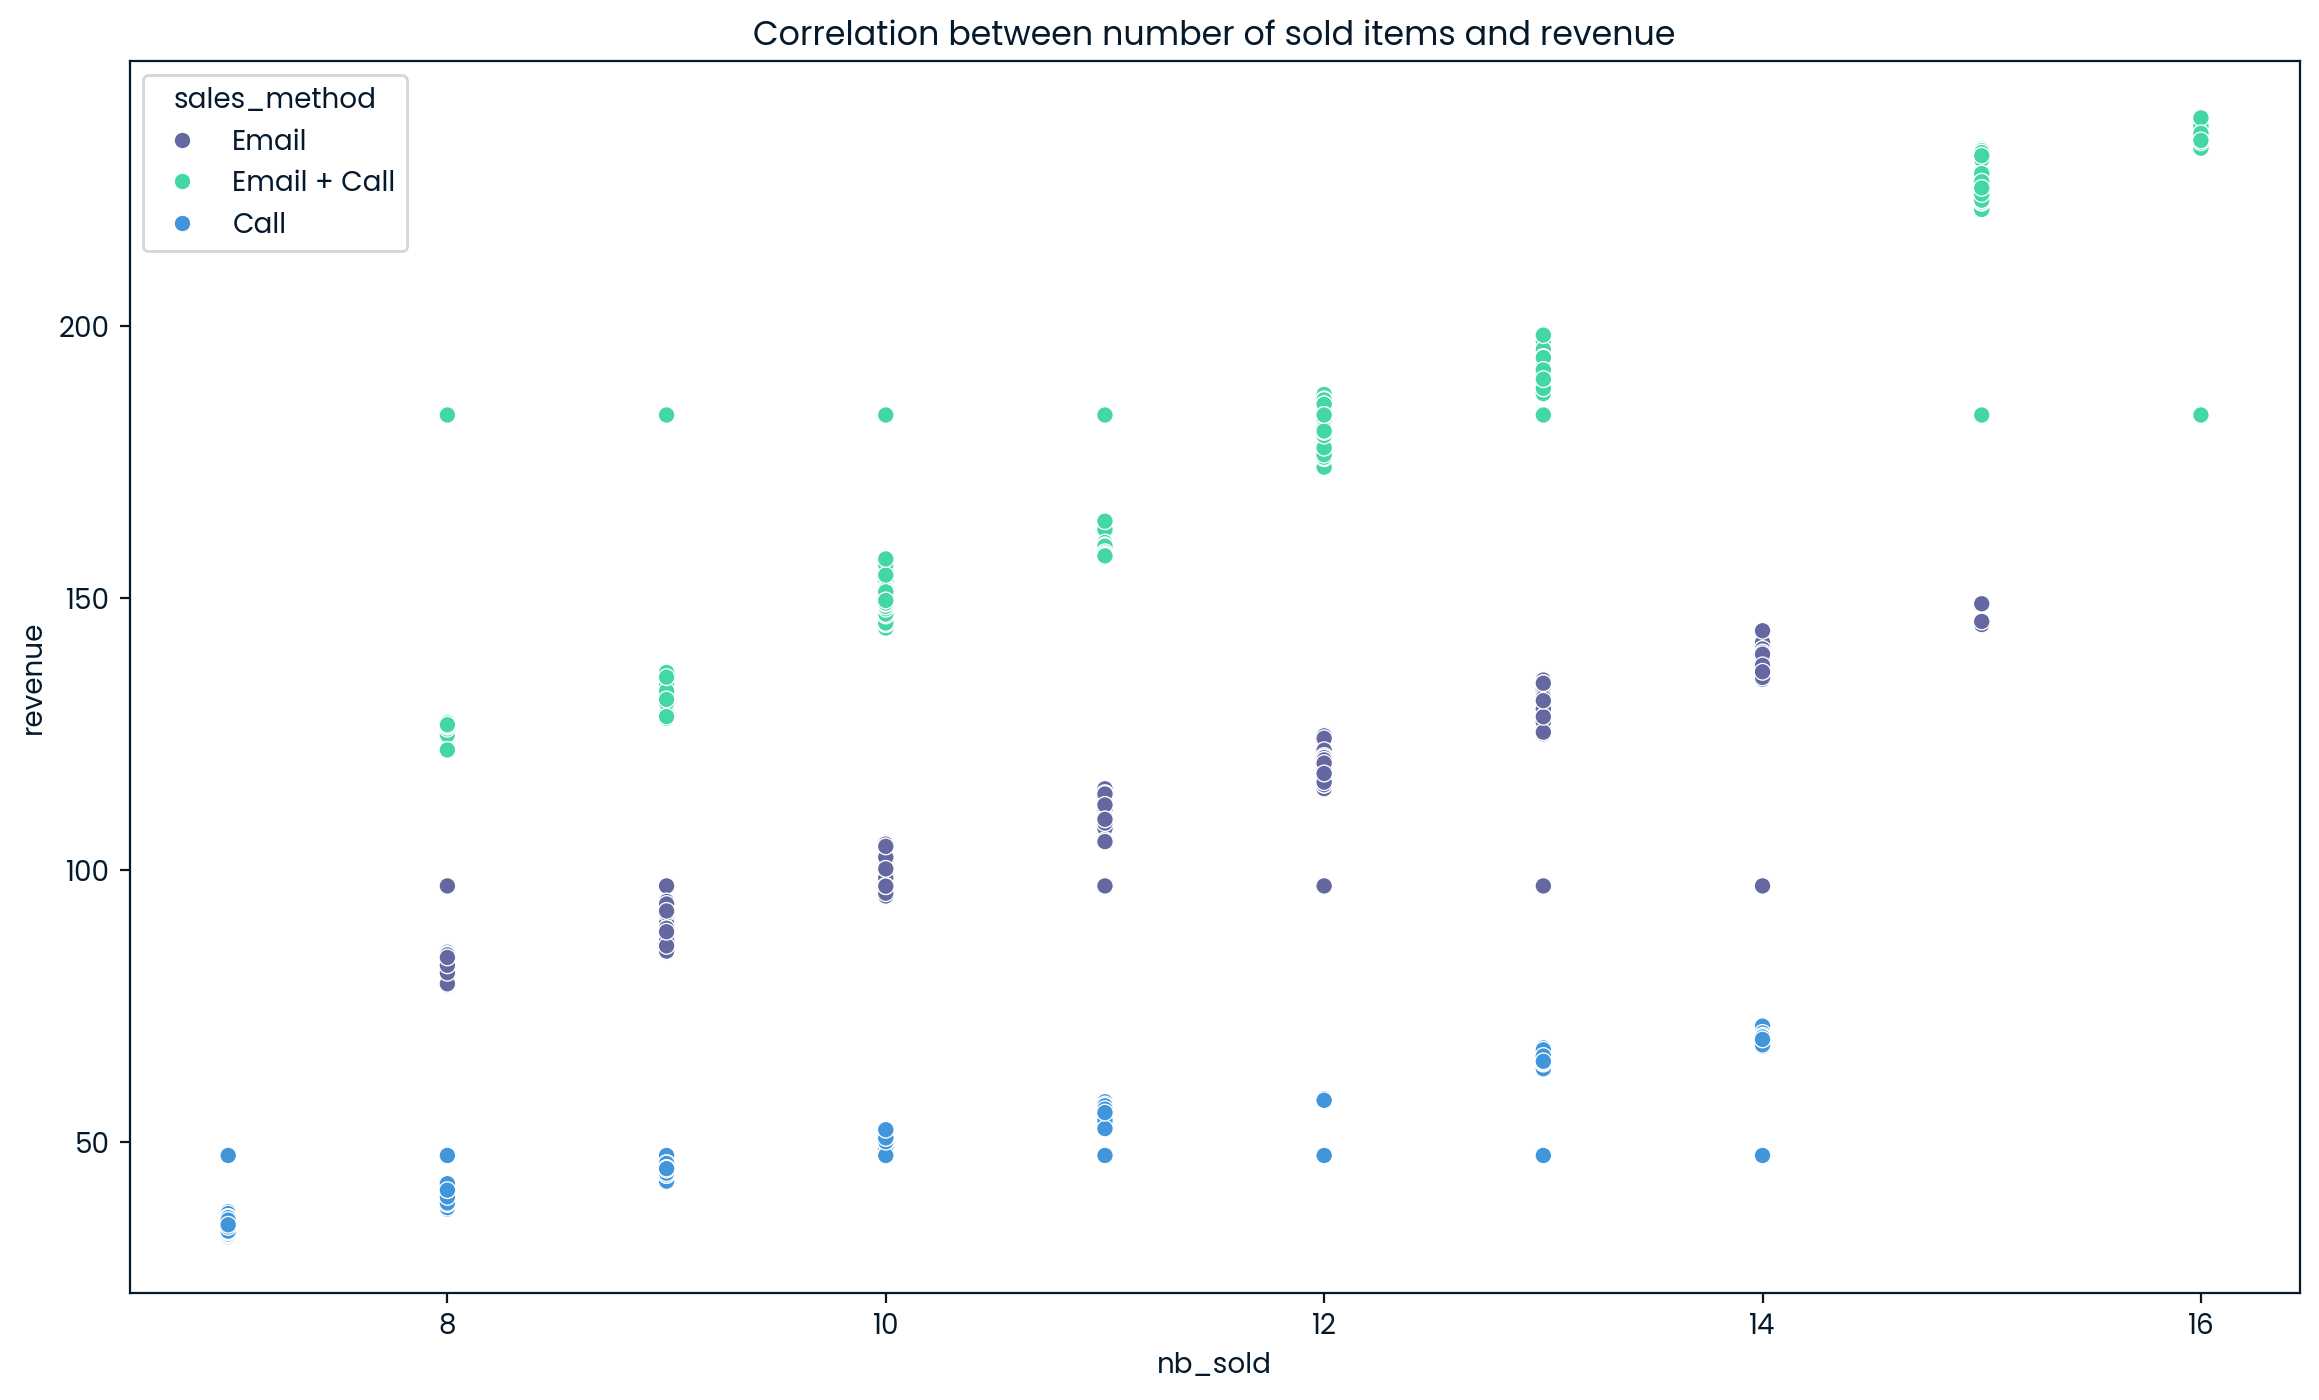

In [39]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='nb_sold', y='revenue', hue='sales_method')
plt.title('Correlation between number of sold items and revenue')
plt.show()

As seen in the graph above, the various sales methods have different slopes which impact the increase in revenue as more items are sold

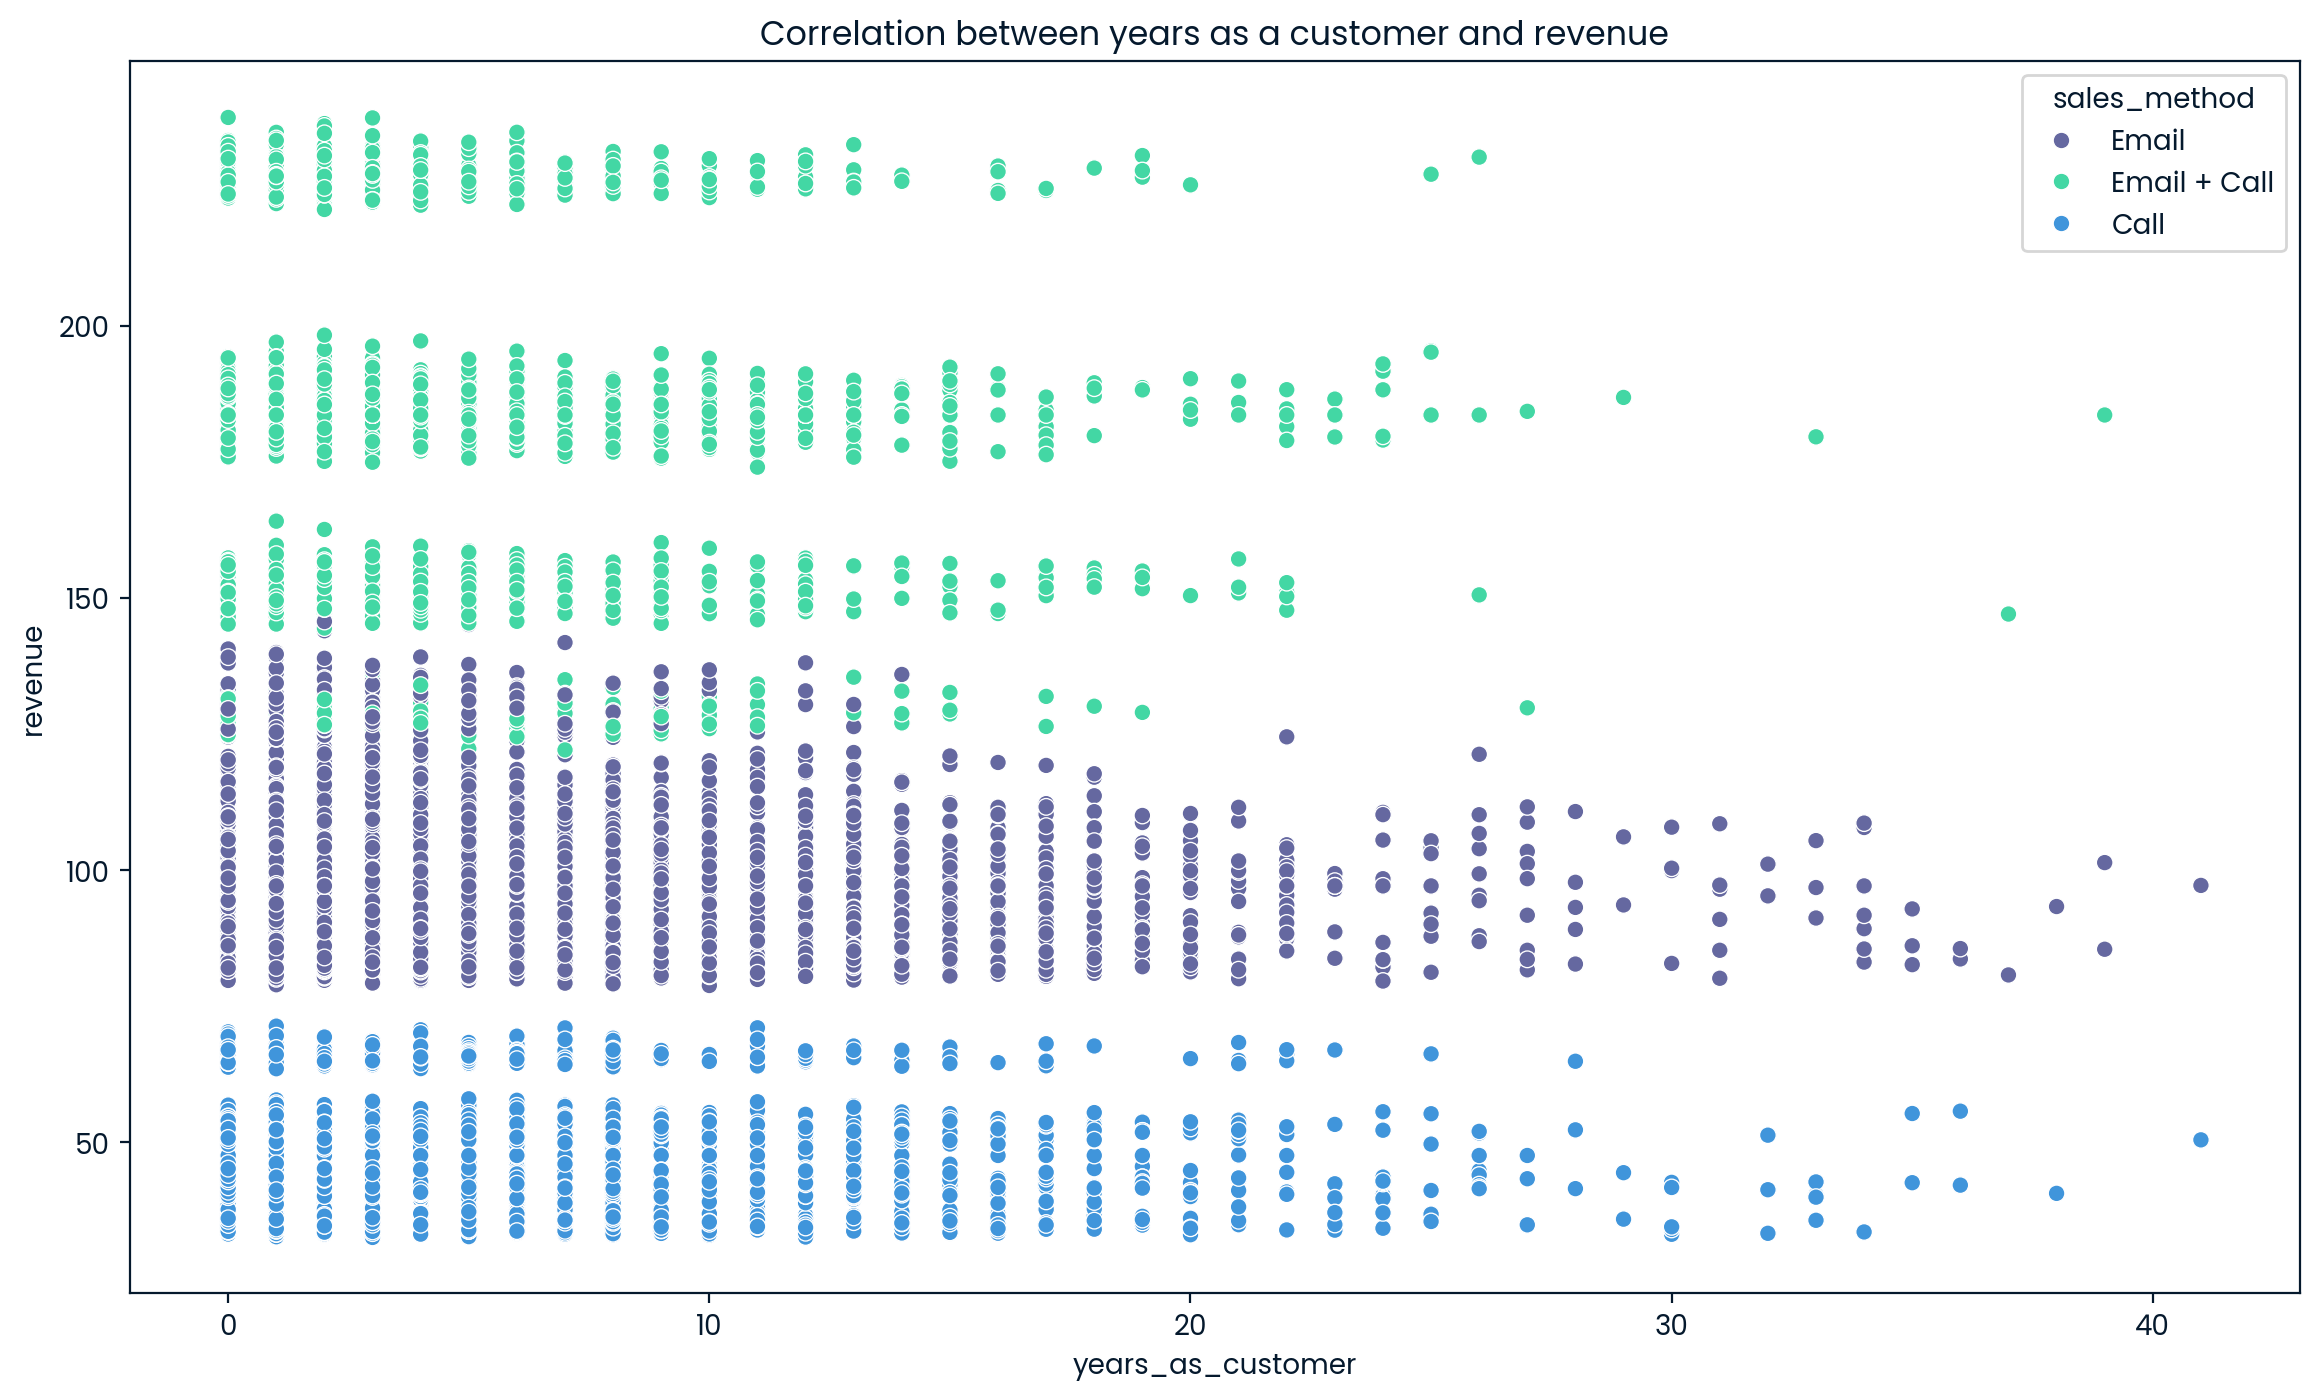

In [40]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='years_as_customer', y='revenue', hue='sales_method')
plt.title('Correlation between years as a customer and revenue')
plt.show()

Surprisingly, there is no correlation or at least very weak negative correlation between old customers and revenue. One would assume that more loyal customers would buy more items or more expensive materials, but it seems the contrary. The company should appreciate both old and new customers.

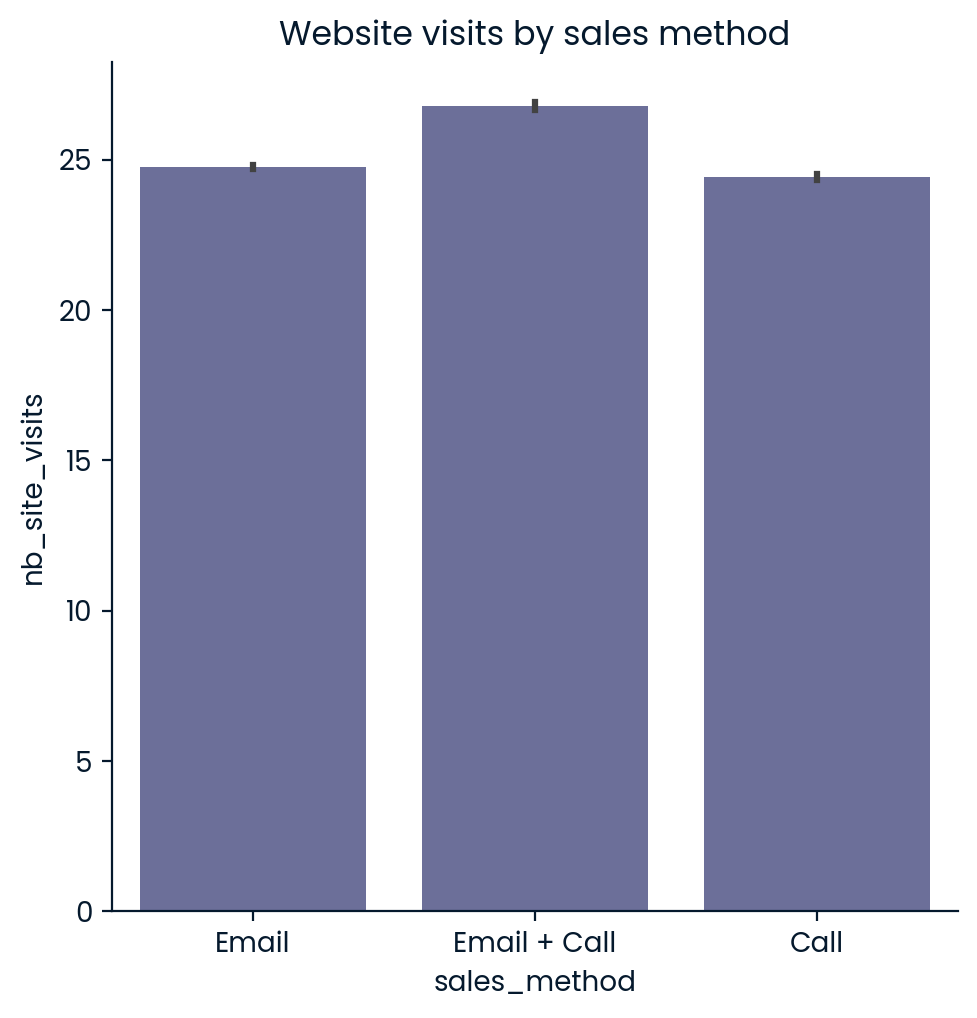

In [41]:
sns.catplot(data=df, x='sales_method', y='nb_site_visits', kind='bar')
plt.title('Website visits by sales method')
plt.show()

From the graph above, we can conclude that there is little difference in the number of visits among the three groups to our website. However, it appears that customers in the "Email + Call" group visited the website slightly more. 

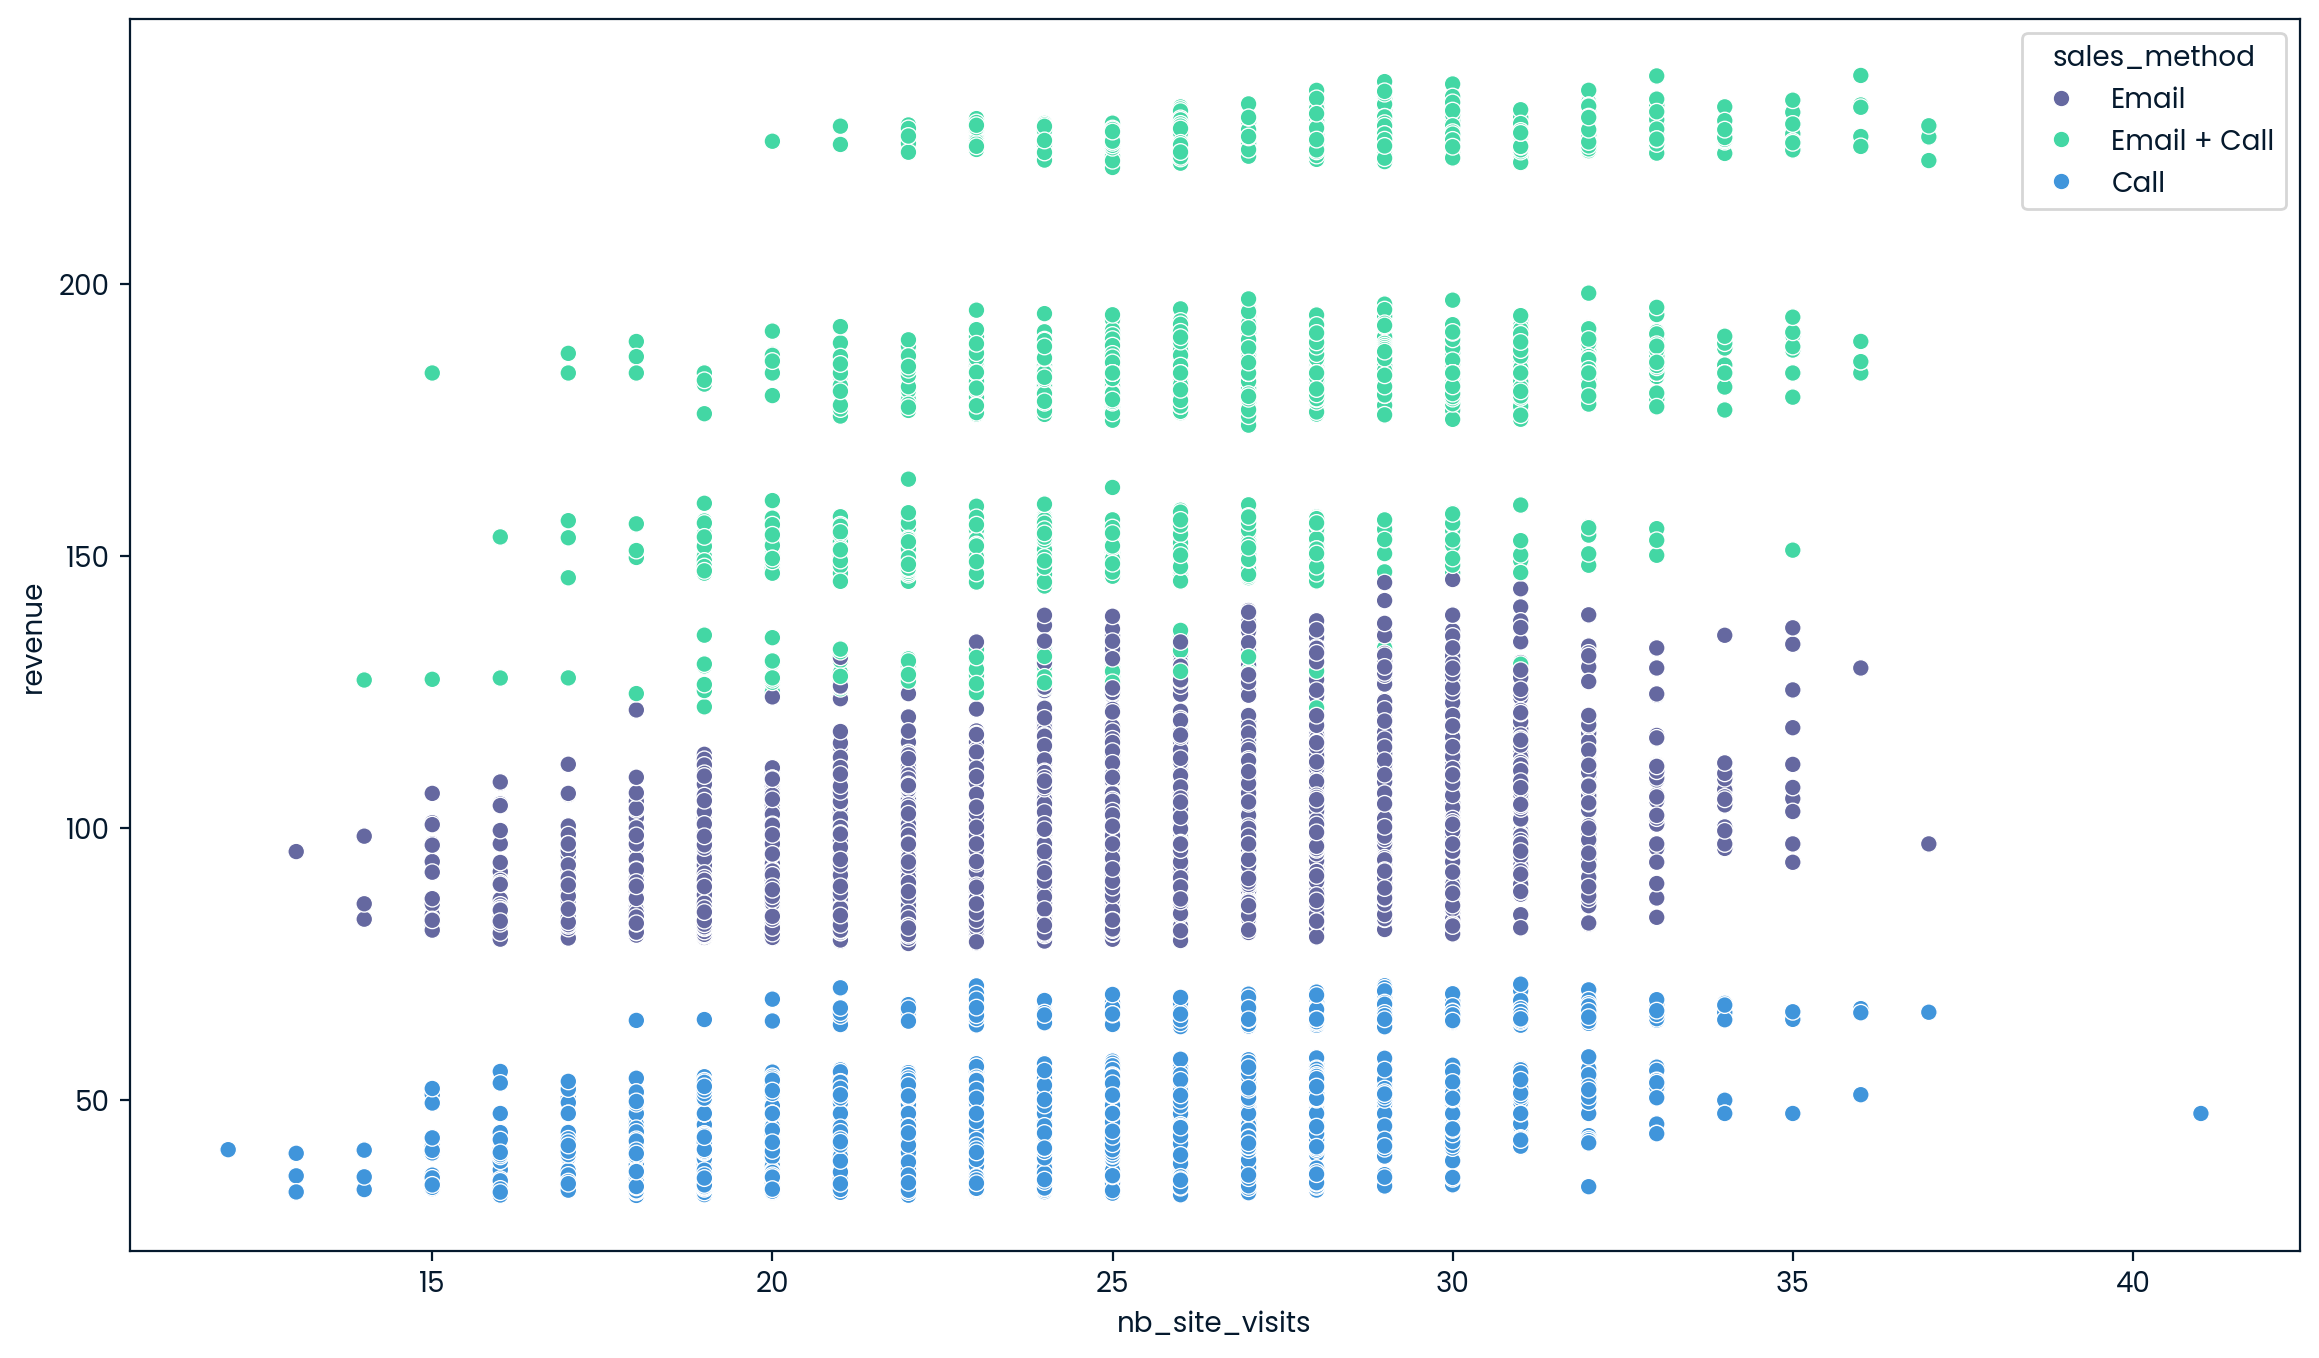

In [42]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='nb_site_visits', y='revenue', hue='sales_method')
plt.show()

And we also see a weak correlation between the number of visits and revenue, which can be explained by the customer's increasing interest in finally purchasing our product.

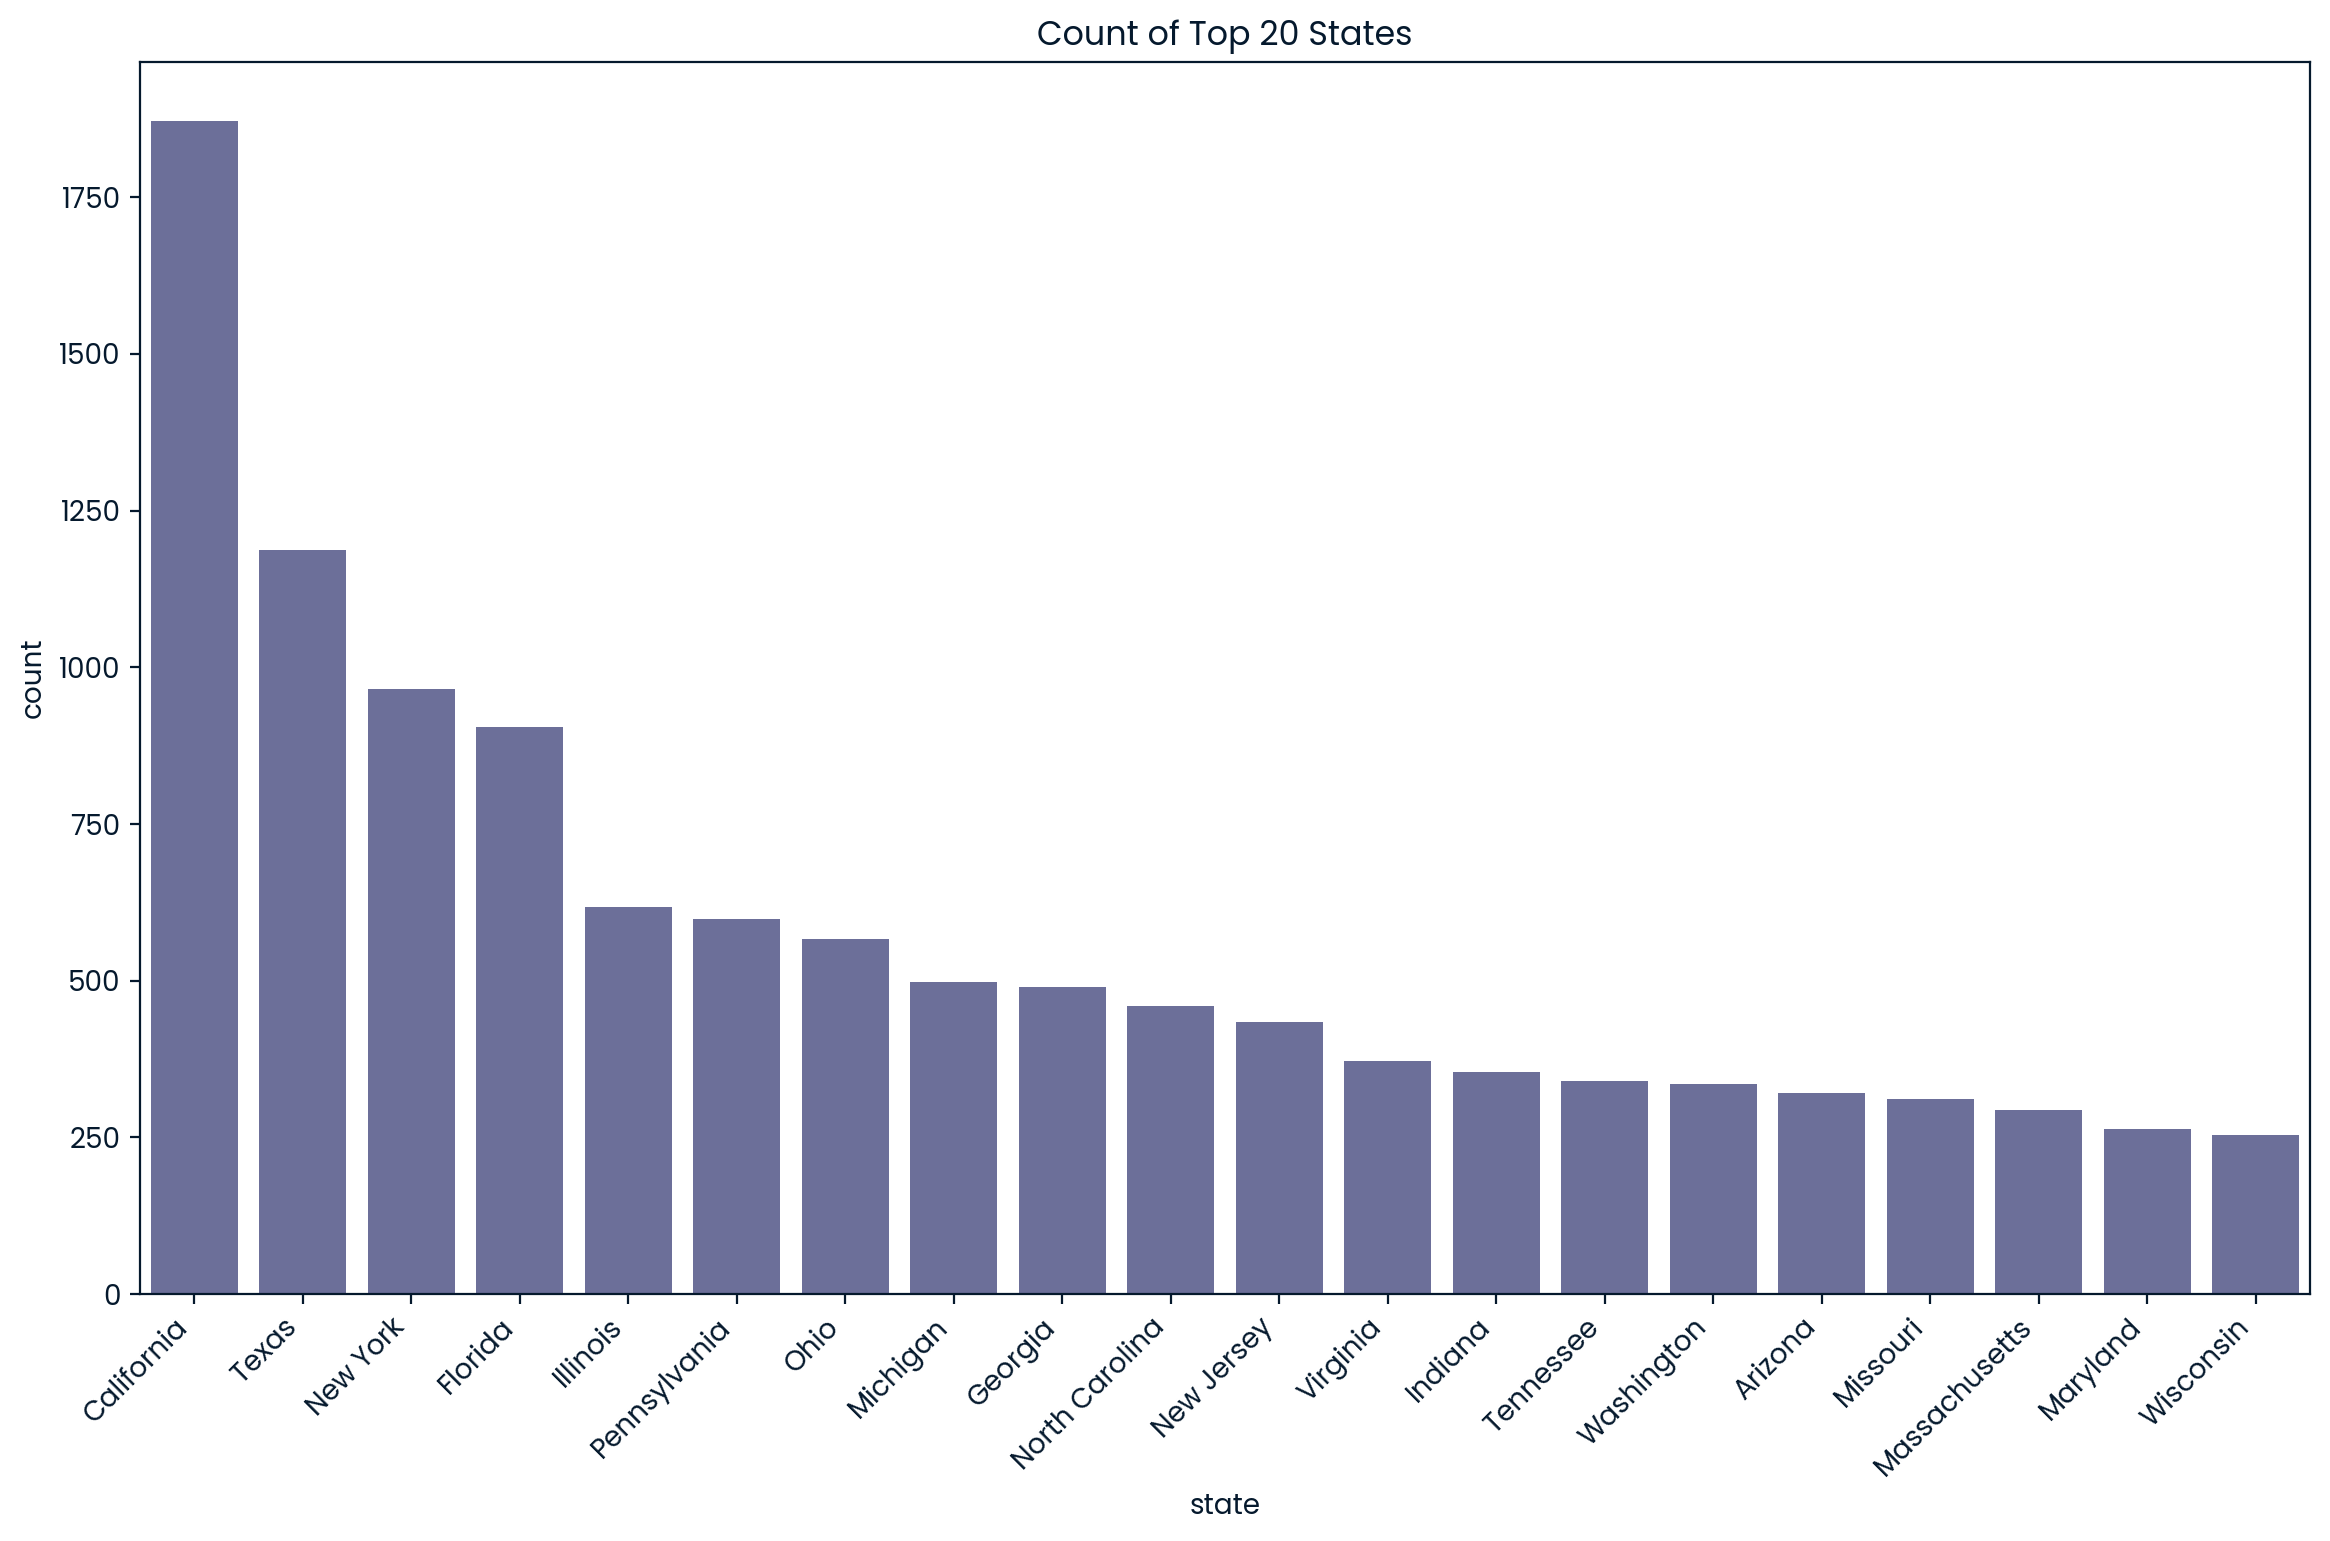

In [43]:
# Filter to show only the top N states (e.g., top 20)
top_states = df['state'].value_counts().nlargest(20).index
filtered_df = df[df['state'].isin(top_states)]

# Get the order of states by count
state_order = df['state'].value_counts().nlargest(20).index

plt.figure(figsize=(14, 8))
sns.countplot(x='state', data=filtered_df, order=state_order)
plt.xticks(rotation=45, ha='right')
plt.title('Count of Top 20 States')
plt.show()


And finally, here we have the top 20 most active states, which can be useful for managing our sales agents and deliveries.

# **Final Summary**

The data provided was in reasonably good condition overall. However, three columns required modification for further analysis. Firstly, the "sales_method" column contained spelling variations between groups. Secondly, the "revenue" column had some missing values, which were substituted with the mean value of each group. Lastly, the "years_as_customer" column had some values greater than the company's age, and for these customers, the age was replaced with the actual age of the company.

After cleaning the data, it was possible to calculate and visualize different types of graphics. The main goal was to evaluate the effectiveness of each sales strategy, using revenue and time spent as the main metrics. From the tables and plots, it could be inferred that the "Email" strategy generated the most revenue, followed by the "Email + Call" strategy. However, in terms of mean revenue per sale, the "Email + Call" strategy performed the best, followed by the "Email" sales method. The "Call" method was the least effective strategy, not only did it generate the lowest revenue, but it also required about four times more time than the other two methods in terms of total time spent.

Based on this analysis, the recommendation would be to reject using the "Call" strategy and focus on the "Email" strategy, which is relatively simple, requires less time, and generates moderate revenue per sale. Additionally, it would be beneficial to focus on the "Email + Call" strategy, as it generates high revenues per sale, despite requiring about double the time compared to the "Email" strategy for each sale.

Regarding other variables, it is evident that over time, revenue and the number of items sold per sale are increasing. This can be attributed to the experience gained as time goes on, providing customers with more valuable and detailed information, leading them to purchase more or pricier items. There is also a strong correlation between the number of items sold and revenue, which is not surprising.

Both old and new customers have a similar profile in terms of generating revenue. Even new customers tend to purchase more expensive or more items, resulting in higher revenue for the company. The company should equally appreciate both groups of customers.

In addition, the more a customer spends on the company's website, the more likely they are to make a purchase, generating higher revenue.

